In [1]:
import os
import glob
import itertools
import numpy as np
import xarray as xr
from scipy.ndimage import rotate
from scipy.integrate import cumtrapz

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
%matplotlib inline
matplotlib.rcParams.update({'font.size':15})
import time
import cartopy.crs as ccrs
import cartopy
CMIP6_FOLDER = "/global/cfs/projectdirs/m3522/cmip6/"
SCRATCH="/global/cscratch1/sd/qnicolas/"

import sys
p = os.path.abspath('/global/homes/q/qnicolas/')
if p not in sys.path:
    sys.path.append(p)
    
from tools.e5tools import *;from tools.generalTools import *;from tools.BLtools import *
from orographicConvectionTheory.orographicConvectionTheory import *
from orographicPrecipitation.observationsAndERA5.mountainUtils import *; from tools.generalTools import *; from tools.BLtools import *
km_per_degreelat = 6370*np.pi/180
mnths=['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']


import metpy.calc as mpcalc
from metpy.plots import SkewT
from metpy.units import units

xr.set_options(display_style='text') 

In [2]:
#from dask.distributed import Client
#client=Client()

# Data loading

In [64]:
def get_spells(condition,nspells=10):
    """from a time series of 0s and 1s, find the longest series of 1s (indices of beginnings, ends+1 and lengths)"""
    days_ext = np.concatenate(([0.],condition,[0.]))
    days_start = np.where(days_ext[1:-1]-days_ext[:-2]>0)[0]
    days_end = np.where(days_ext[2:]-days_ext[1:-1]<0)[0]+1
    spell_lengths = days_end-days_start
    spells_idx = np.argsort(spell_lengths)[-nspells:]
    return days_start[spells_idx],days_end[spells_idx],spell_lengths[spells_idx]

In [65]:
def get_subspells(condition,spell_length):
    """from a time series of 0s and 1s, find the longest series of 1s (indices of beginnings, ends+1 and lengths)"""
    days_ext = np.concatenate(([0.],condition,[0.]))
    days_start = np.where(days_ext[1:-1]-days_ext[:-2]>0)[0]
    days_end = np.where(days_ext[2:]-days_ext[1:-1]<0)[0]+1
    spell_lengths = days_end-days_start
    sub_spell_start   = []
    sub_spell_end     = []
    sub_spell_lengths = []
    for i,sl in enumerate(spell_lengths):
        r = sl//spell_length
        if r>=1:
            ssl = sl//r
            sub_spell_start += [days_start[i]+j*ssl for j in range(r)]
            sub_spell_end += [days_start[i]+(j+1)*ssl for j in range(r-1)]+[days_end[i]]
            sub_spell_lengths += [ssl for j in range(r-1)]+[ssl+sl%r]
    return sub_spell_start,sub_spell_end,sub_spell_lengths

In [24]:
def get_binned(a,b,bins):
    bins=bins[(bins>float(a.min()))&(bins<float(a.max()))]
    bin_centers=(bins[1:]+bins[:-1])/2
    digitized = np.digitize(np.array(a), bins)
    bin_means = np.array([np.array(b)[digitized == i].mean() for i in range(1, len(bins))])
    return bin_centers,bin_means

In [66]:
# Monthly data loading
orogm=xr.open_dataset(CMIP6_FOLDER+"ERA5/e5.oper.invariant/197901/e5.oper.invariant.128_129_z.ll025sc.1979010100_1979010100.nc").Z.isel(time=0)/9.81
gpm_pr_seasmean=xr.open_dataarray("/global/cscratch1/sd/qnicolas/temp/GPM-IMERG-seasonalmean-200101-201812.nc")
era5100u=xr.open_dataarray("/global/cscratch1/sd/qnicolas/temp/e5.climatology.228_246_100u.2001-2018.nc")
era5100v=xr.open_dataarray("/global/cscratch1/sd/qnicolas/temp/e5.climatology.228_247_100v.2001-2018.nc")

In [67]:
# Daily stuff
box_wind_upstream = [71,73,12,16]
box_precip_above  = [73,76,13,15]
box_bob=[82,90,12,18]

era5t_ghatswide_jjahourly = xr.concat((xr.open_zarr("/global/cscratch1/sd/qnicolas/regionsData/e5.oper.an.pl.128_130_t.ll025sc.%i%s.ghatswide.zarr"%(year,month)) for year,month in itertools.product(range(2001,2016),('06','07','08'))),dim='time').T
era5u_ghatswide_jjahourly = xr.concat((xr.open_zarr("/global/cscratch1/sd/qnicolas/regionsData/e5.oper.an.pl.128_131_u.ll025sc.%i%s.ghatswide.zarr"%(year,month)) for year,month in itertools.product(range(2001,2016),('06','07','08'))),dim='time').U
era5w_ghatswide_jjahourly = xr.concat((xr.open_zarr("/global/cscratch1/sd/qnicolas/regionsData/e5.oper.an.pl.128_135_w.ll025sc.%i%s.ghatswide.zarr"%(year,month)) for year,month in itertools.product(range(2001,2016),('06','07','08'))),dim='time').W
era5pr_hourly = xr.open_mfdataset(sorted(glob.glob("/global/cfs/projectdirs/m3522/cmip6/ERA5/e5.generated_tp/ERA5_IVT_tp_reanalysis_*.nc"))[22:-3])
era5pr_ghatswide_hourly = sel_box_month(era5pr_hourly,[68,85,13,15],0).tp
ghatswide_topo = sel_box_month(orogm,[68,85,13,15],0).mean('latitude')

gpmpr_ghatswide_jjadaily = xr.concat((xr.open_zarr("/global/cscratch1/sd/qnicolas/regionsData/gpm_imerg_v06.2001-2015.%s.ghatswide.zarr"%month).precipitationCal for month in ('06','07','08')),dim="time").sortby('time')
gpmpr_above_daily = sel_box_month(gpmpr_ghatswide_jjadaily,box_precip_above,0).mean(['latitude','longitude']).load()

climcapst_ghatswide_jjadaily = xr.concat((xr.open_zarr("/global/cscratch1/sd/qnicolas/regionsData/L3_CLIMCAPS_QCC.air_temp.2002-2015.%s.ghatswide.zarr"%month).air_temp for month in ('06','07','08')),dim="time").sortby('time')
climcapst_ghatswide_jjadaily = climcapst_ghatswide_jjadaily.assign_coords(level=climcapst_ghatswide_jjadaily.air_pres/100).swap_dims({'air_pres':'level'})

era5100u_ghats_julhourly = xr.open_zarr("/global/cscratch1/sd/qnicolas/regionsData/e5.oper.an.sfc.228_246_100u.ll025sc.2001-2015.07.ghats.zarr").VAR_100U
era5100u_ghats_daily = era5100u_ghats_julhourly.resample(time='1D').mean()
era5100u_ghats_daily=era5100u_ghats_daily.sel(time=(era5100u_ghats_daily['time.month']==7))
u_upstream_daily = sel_box_month(era5100u_ghats_daily,box_wind_upstream,0).mean(['latitude','longitude']).load()


In [8]:
era5z_ghats_ref = sel_box_month(xr.open_dataset("/global/project/projectdirs/m3310/wboos/era5monthlyQuentin/e5.moda.an.pl/e5.moda.an.pl.128_129_z.ll025sc.2010010100_2010120100.nc").Z,
                          box_wind_upstream,0)[6].mean(['latitude','longitude'])/9.81
box_ref_rce = [68,69,12,17]
climcapst_climatology = xr.open_zarr("/global/cscratch1/sd/qnicolas/CLIMCAPS_V2/monthly/L3_CLIMCAPS_QCC.air_temp.monthly.zarr").air_temp.groupby('time.month').mean(['time','orbit_pass'])
climcapst_ghats_ref = sel_box_month(climcapst_climatology,box_ref_rce,7).mean(['latitude','longitude']).assign_coords({'level':climcapst_climatology.air_pres/100}).swap_dims({'air_pres':'level'}).load()
era5t_ghats_climatology = xr.open_dataarray("/global/cscratch1/sd/qnicolas/regionsData/e5.climatology.128_130_t.ghats.2001-2019.nc")
era5t_ghats_ref = sel_box_month(era5t_ghats_climatology,box_ref_rce,0).mean(['latitude','longitude'])


In [9]:
from scipy.interpolate import interp1d
z_ghats_ref_interp = interp1d(np.log(era5z_ghats_ref.level),era5z_ghats_ref,fill_value="extrapolate")(np.log(climcapst_ghats_ref.level))


# Dry spells over the Bay of Bengal

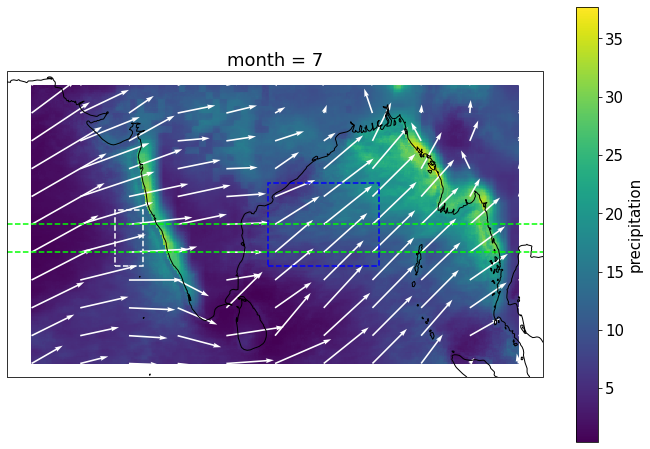

In [13]:
def sela(ar):
    return ar.sel(month=7,latitude=slice(25,5),longitude=slice(65,100))
fig,ax = plt.subplots(1,1,figsize=(12,8),subplot_kw={"projection":ccrs.PlateCarree()})
sela(gpm_pr_seasmean).plot(ax=ax)
u=sela(era5100u);v=sela(era5100v)
X = u.latitude.expand_dims({"longitude":u.longitude}).transpose()
Y = u.longitude.expand_dims({"latitude":u.latitude})
n=len(u.latitude)//10
m=len(u.longitude)//10
q=ax.quiver(np.array(Y)[::n,::m],np.array(X)[::n,::m], np.array(u)[::n,::m], np.array(v)[::n,::m], transform=ccrs.PlateCarree(),color="w",width=0.003,scale=90)
ax.coastlines()


#Boxes
for smallbox,clr in ((box_bob,'b'),(box_wind_upstream,'w')):
    ax.add_patch(mpatches.Rectangle(xy=[smallbox[0], smallbox[2]], width=smallbox[1]-smallbox[0], height=smallbox[3]-smallbox[2],
                                       edgecolor=clr,
                                       fill = False,
                                       lw=1.5,
                                       linestyle='--',
                                       transform=ccrs.PlateCarree())
                    )
ax.axhline(13.,color='lime',lw=1.5,linestyle='--')
ax.axhline(15.,color='lime',lw=1.5,linestyle='--')

In [47]:
precip_bob = xr.open_zarr("/global/cscratch1/sd/qnicolas/regionsData/gpm_imerg_v06.2001-2015.07.bayofbengal.zarr")
pr_bob_tseries = precip_bob.precipitationCal.mean(['latitude','longitude']).load()

nspells=10
dryspells_start,dryspells_end,dryspells_lengths = get_spells(pr_bob_tseries<4)
dryspells_lengths

array([ 5,  5,  6,  7,  8, 10, 11, 11, 11, 12])

In [37]:
meanu = u_upstream_daily.mean() # 9.6 m/s
stdu = u_upstream_daily.std()   # 2.2 m/s

In [38]:
for i in range(nspells):
    print("%i-day dry spell, %.2f mm/day, %.2f m/s"%(dryspells_lengths[i],
                                                     pr_bob_tseries[dryspells_start[i]:dryspells_end[i]].mean('time'),
                                                     u_upstream_daily[dryspells_start[i]:dryspells_end[i]].mean('time')))

5-day dry spell, 0.71 mm/day, 10.40 m/s
5-day dry spell, 0.18 mm/day, 10.23 m/s
6-day dry spell, 0.39 mm/day, 8.16 m/s
7-day dry spell, 1.04 mm/day, 9.73 m/s
8-day dry spell, 0.60 mm/day, 12.24 m/s
10-day dry spell, 0.64 mm/day, 8.06 m/s
11-day dry spell, 1.42 mm/day, 9.10 m/s
11-day dry spell, 0.76 mm/day, 12.25 m/s
11-day dry spell, 1.26 mm/day, 8.13 m/s
12-day dry spell, 0.72 mm/day, 9.55 m/s


/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/matplotlib/contour.py:1494: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/matplotlib/contour.py:1495: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages

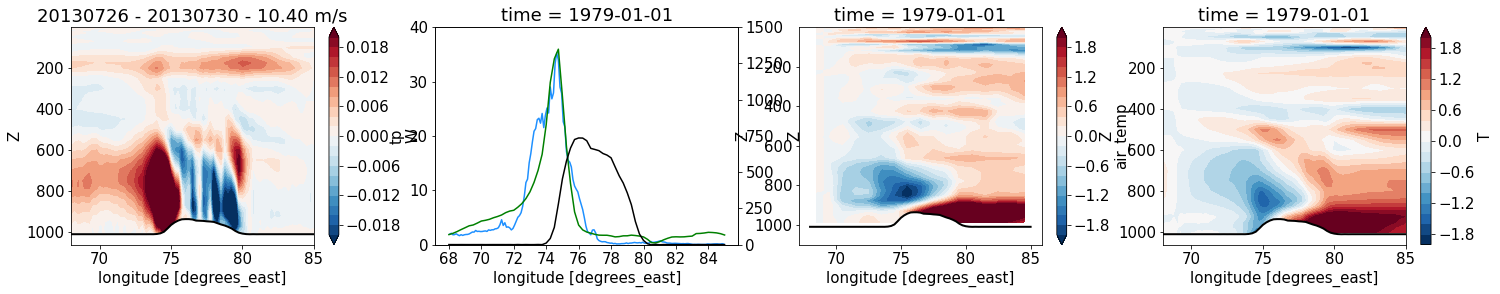

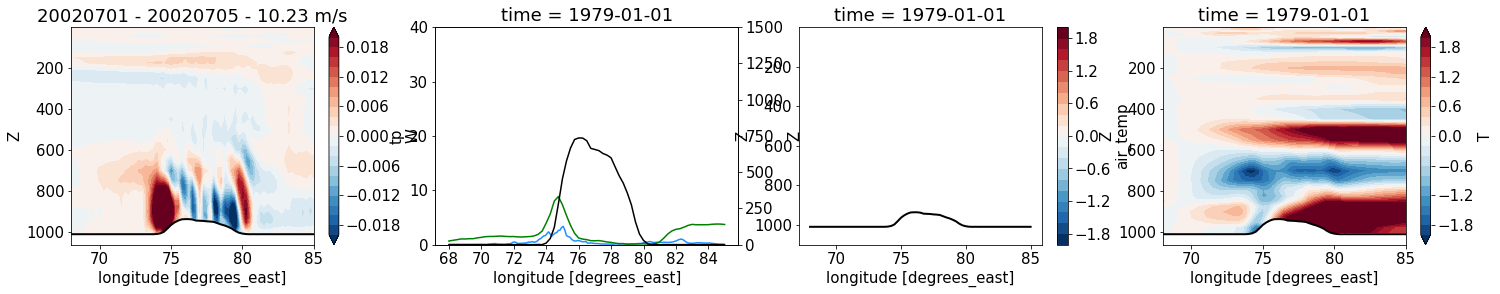

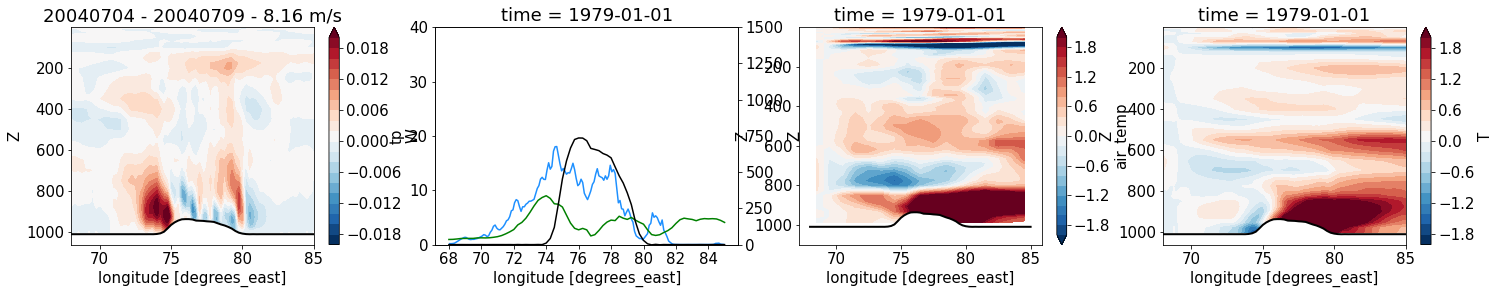

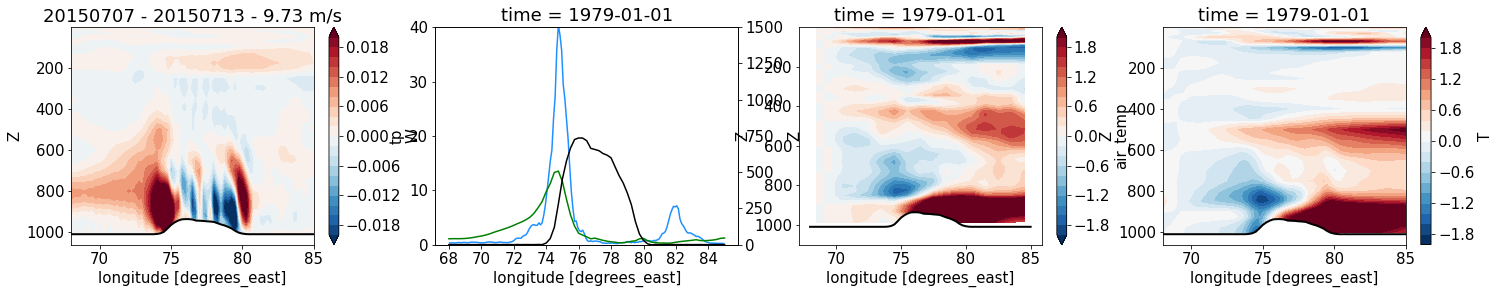

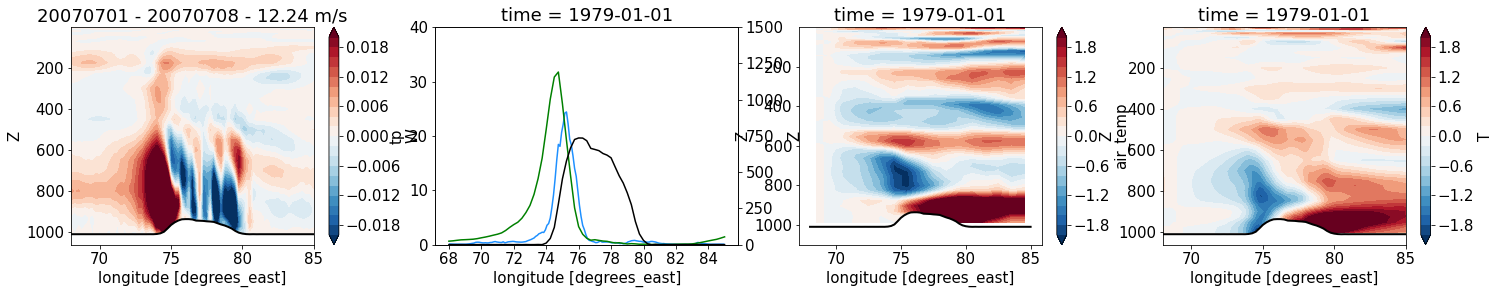

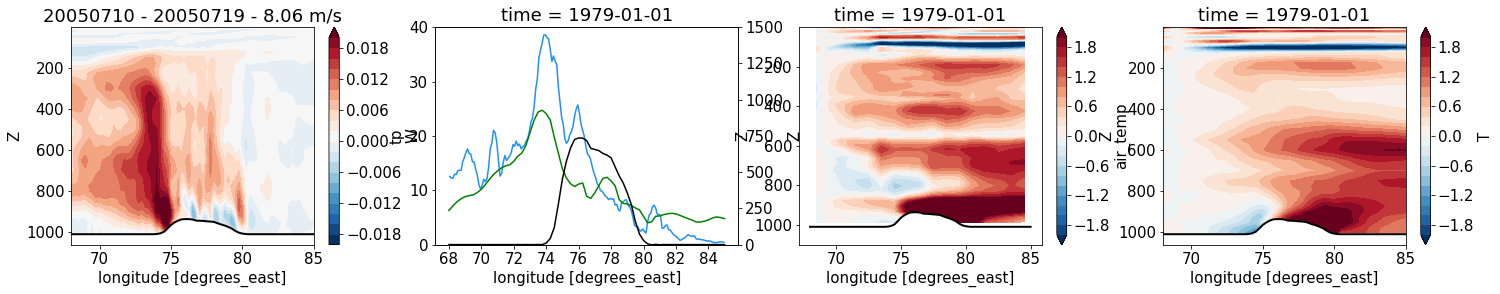

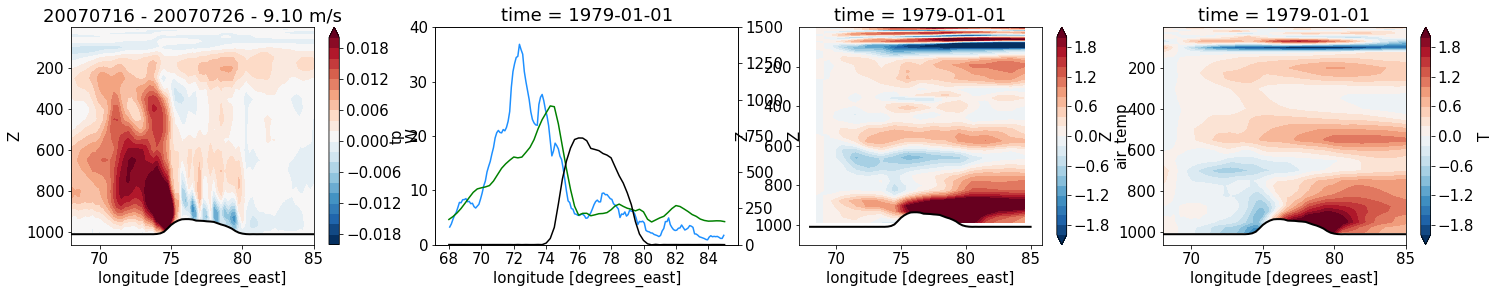

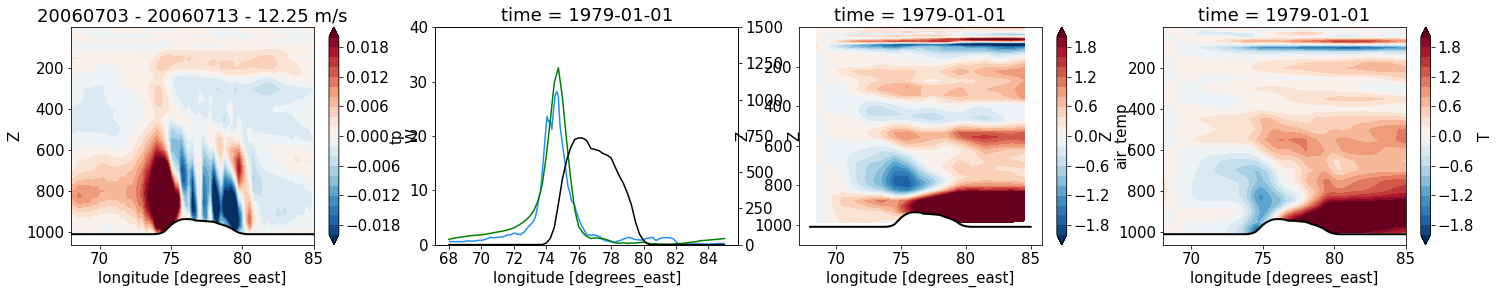

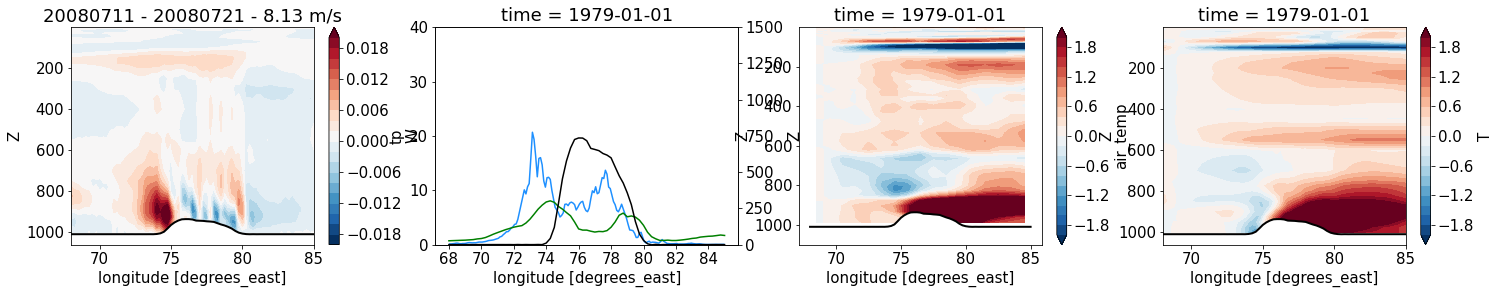

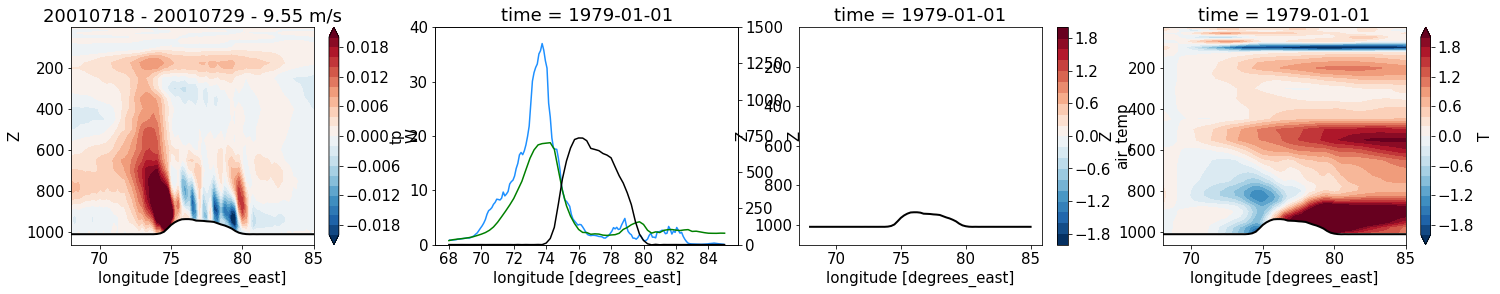

In [130]:
for i in range(nspells):
    days = np.array(pr_bob_tseries[dryspells_start[i]:dryspells_end[i]].time)
    days_str = pd.to_datetime(days).strftime('%Y%m%d')
    
    era5w = era5w_ghatswide_julhourly.sel(time=slice(days_str[0],days_str[-1])).sel(latitude=slice(15,13)).mean(['time','latitude']).load()
    era5t = era5t_ghatswide_julhourly.sel(time=slice(days_str[0],days_str[-1])).sel(latitude=slice(15,13)).mean(['time','latitude']).load()
    era5tprime = era5t-era5t.sel(longitude=slice(68,70)).mean('longitude')
    era5pr = era5pr_ghatswide_hourly.sel(time=slice(days_str[0],days_str[-1])).mean(['time','latitude']).load()*(1000*24)
    gpmpr = gpmpr_ghatswide_juldaily.sel(time=slice(days_str[0],days_str[-1])).sel(latitude=slice(15,13)).mean(['time','latitude']).load()
    
    airst = climcapst_ghatswide_juldaily.sel(time=slice(days_str[0],days_str[-1])).sel(latitude=slice(15,13)).mean(['time','latitude']).load()
    airstprime=airst-airst.sel(longitude=slice(68,70)).mean('longitude')
    
    _,(ax1,ax2,ax3,ax4) = plt.subplots(1,4,figsize=(25,4))
    #W
    (-era5w/10).plot.contourf(ax=ax1,y='level',yincrease=False,levels=np.linspace(-0.02,0.02,21),cmap=plt.cm.RdBu_r)
    
    #PRECIPS
    gpmpr.plot(ax=ax2,label='GPM precip',color='dodgerblue')
    era5pr.plot(ax=ax2,label='ERA5 precip',color='g')
    ax22=ax2.twinx()
    ghatswide_topo.plot(ax=ax22,color='k')
    ax2.set_ylim(0,40)
    ax22.set_ylim(0,1500)
    ax2.set_xticks(np.arange(68,86,2));None
    
    #airs T
    airstprime.plot.contourf(ax=ax3,y='level',yincrease=False,levels=np.linspace(-2,2,21),cmap=plt.cm.RdBu_r)
    #ERA5 T
    era5tprime.plot.contourf(ax=ax4,y='level',yincrease=False,levels=np.linspace(-2,2,21),cmap=plt.cm.RdBu_r)

    for ax in (ax1,ax3,ax4):
        ax.fill_between(ghatswide_topo.longitude,1010*ghatswide_topo**0,1010-ghatswide_topo/10,color='w')
        (1010-ghatswide_topo/10).plot(ax=ax,color='k',linewidth=2)
    ax1.set_title(days_str[0]+" - "+days_str[-1]+ " - %.2f m/s"%(u_upstream_daily[dryspells_start[i]:dryspells_end[i]].mean('time')))
    
    


/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/matplotlib/contour.py:1494: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/matplotlib/contour.py:1495: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages

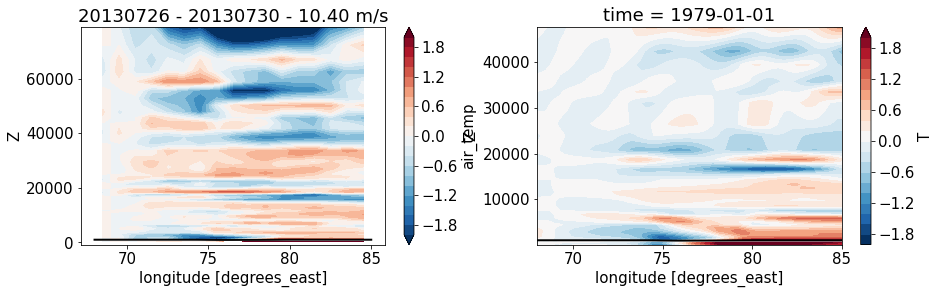

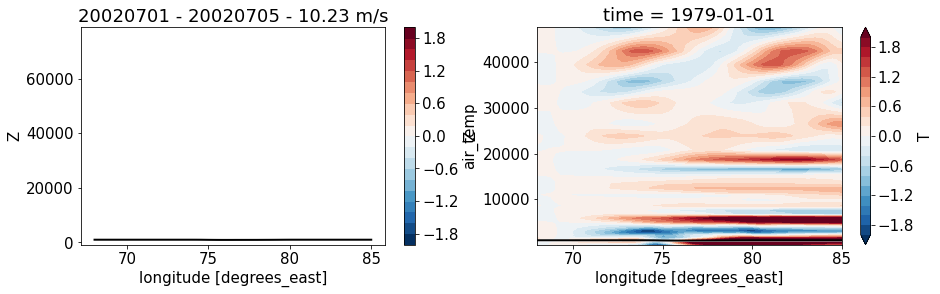

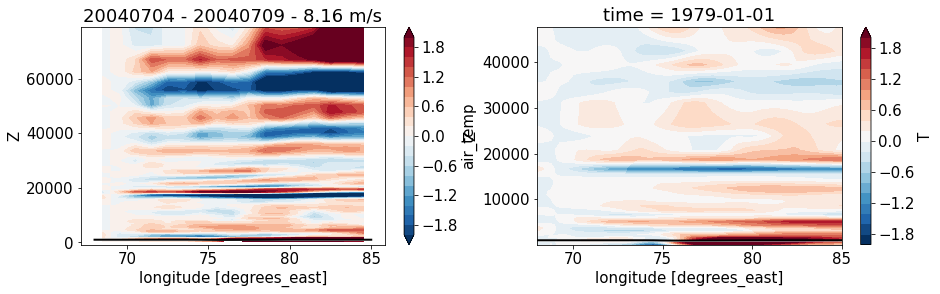

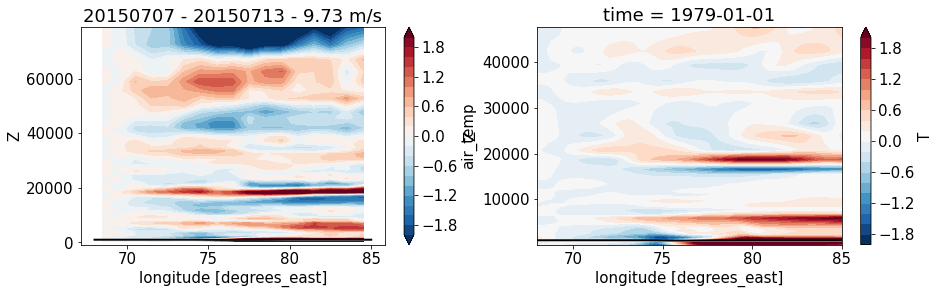

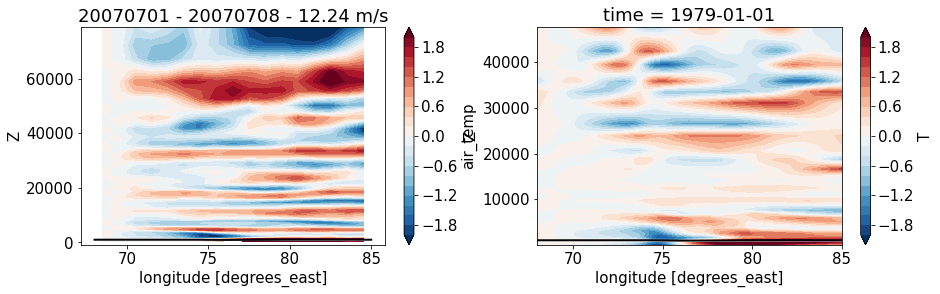

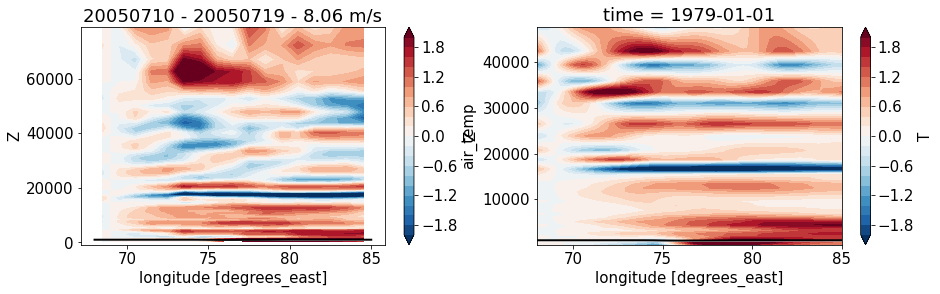

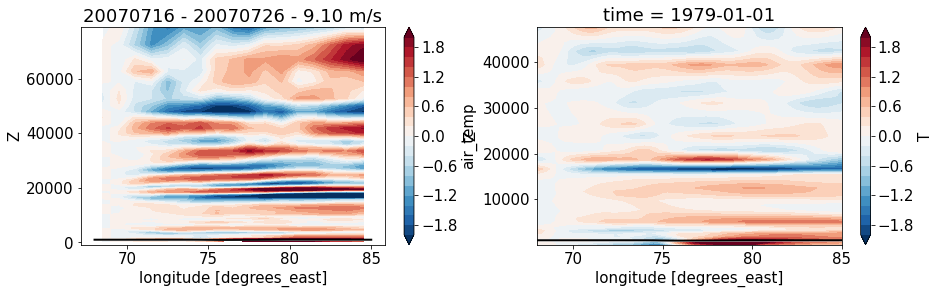

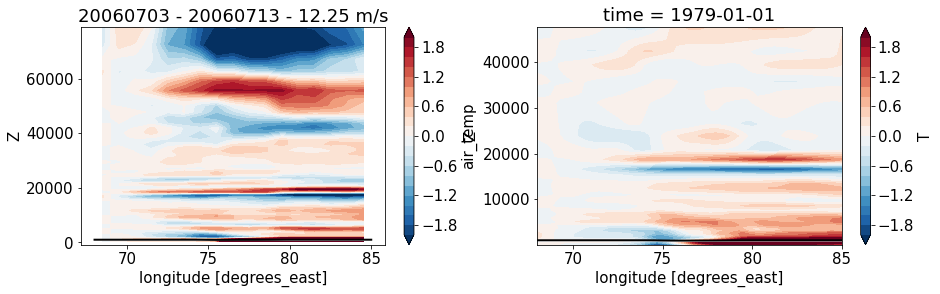

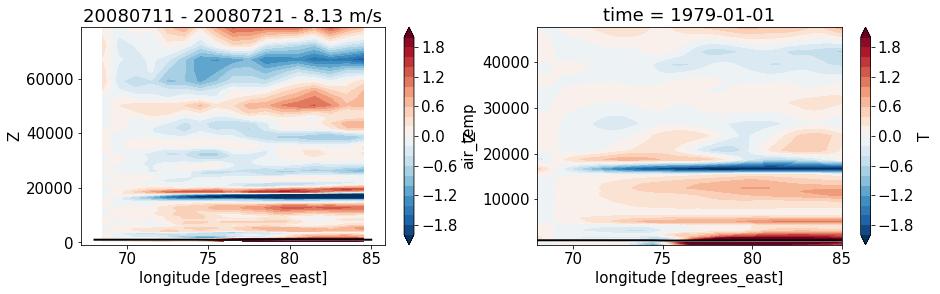

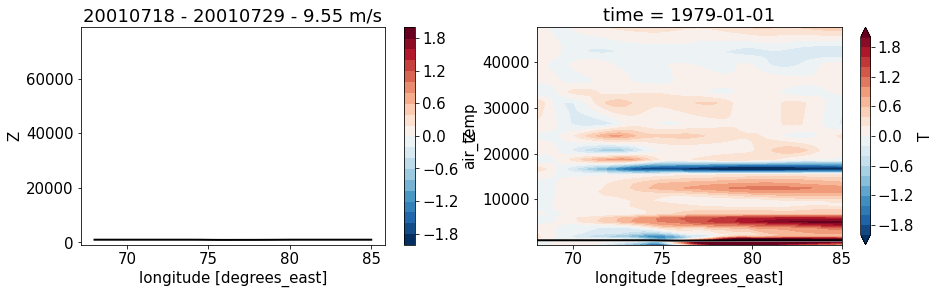

In [151]:
for i in range(nspells):
    days = np.array(pr_bob_tseries[dryspells_start[i]:dryspells_end[i]].time)
    days_str = pd.to_datetime(days).strftime('%Y%m%d')
    
    era5t = era5t_ghatswide_julhourly.sel(time=slice(days_str[0],days_str[-1])).sel(latitude=slice(15,13)).mean(['time','latitude']).load().assign_coords({'z':era5z_ghats_ref})
    era5tprime = era5t-era5t.sel(longitude=slice(68,70)).mean('longitude')
     
    airst = climcapst_ghatswide_juldaily.sel(time=slice(days_str[0],days_str[-1])).sel(latitude=slice(15,13)).mean(['time','latitude']).load().assign_coords({'z':('level',z_ghats_ref_interp)})
    airstprime=airst-airst.sel(longitude=slice(68,70)).mean('longitude')
    
    _,(ax3,ax4) = plt.subplots(1,2,figsize=(15,4))

    #airs T
    airstprime.plot.contourf(ax=ax3,y='z',levels=np.linspace(-2,2,21),cmap=plt.cm.RdBu_r)
    #ERA5 T
    era5tprime.plot.contourf(ax=ax4,y='z',levels=np.linspace(-2,2,21),cmap=plt.cm.RdBu_r)

    for ax in (ax1,ax3,ax4):
        ax.fill_between(ghatswide_topo.longitude,1010*ghatswide_topo**0,1010-ghatswide_topo/10,color='w')
        (1010-ghatswide_topo/10).plot(ax=ax,color='k',linewidth=2)
    ax3.set_title(days_str[0]+" - "+days_str[-1]+ " - %.2f m/s"%(u_upstream_daily[dryspells_start[i]:dryspells_end[i]].mean('time')))
    
    


# With integrated wind

In [75]:
def monthsel(month,monthinf,monthsup):
    return (np.mod(month - monthinf,12) < np.mod(monthsup - monthinf,12)) & (np.mod(monthsup - month,12) <= np.mod(monthsup - monthinf,12))

In [76]:
era5uitg_ghats_daily = era5u_ghatswide_jjahourly.sel(level=slice(700,1100)).resample(time='1D').mean().mean('level')
era5uitg_ghats_daily = era5uitg_ghats_daily.sel(time=(monthsel(era5uitg_ghats_daily['time.month'],6,9)))
uitg_upstream_daily = sel_box_month(era5uitg_ghats_daily,box_wind_upstream,0).mean(['latitude','longitude']).load()


/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [77]:
#nspells=10
#itgwindyspells_start,itgwindyspells_end,itgwindyspells_lengths = get_spells(uitg_upstream_daily>15,nspells)
itgwindyspells_start,itgwindyspells_end,itgwindyspells_lengths = get_subspells(uitg_upstream_daily>15,6)
nspells = len(itgwindyspells_start)
for i in range(nspells):
    days = np.array(uitg_upstream_daily[itgwindyspells_start[i]:itgwindyspells_end[i]].time)
    days_str = pd.to_datetime(days).strftime('%Y%m%d')
    
    print("%s - %s, %i-day vertically integrated windy spell, %.2f mm/day, %.2f m/s"%(days_str[0],days_str[-1],itgwindyspells_lengths[i],
                                                                         gpmpr_above_daily  [itgwindyspells_start[i]:itgwindyspells_end[i]].mean('time'),
                                                                         uitg_upstream_daily[itgwindyspells_start[i]:itgwindyspells_end[i]].mean('time')))

20010703 - 20010710, 8-day vertically integrated windy spell, 15.15 mm/day, 17.27 m/s
20020808 - 20020813, 6-day vertically integrated windy spell, 30.39 mm/day, 16.45 m/s
20040612 - 20040617, 6-day vertically integrated windy spell, 4.51 mm/day, 18.21 m/s
20050724 - 20050730, 7-day vertically integrated windy spell, 23.79 mm/day, 17.47 m/s
20050731 - 20050806, 7-day vertically integrated windy spell, 10.83 mm/day, 17.33 m/s
20060625 - 20060630, 6-day vertically integrated windy spell, 28.38 mm/day, 16.20 m/s
20060701 - 20060706, 6-day vertically integrated windy spell, 6.55 mm/day, 19.31 m/s
20060811 - 20060816, 6-day vertically integrated windy spell, 14.74 mm/day, 16.16 m/s
20070627 - 20070702, 6-day vertically integrated windy spell, 18.88 mm/day, 18.30 m/s
20070703 - 20070709, 7-day vertically integrated windy spell, 11.86 mm/day, 16.32 m/s
20070804 - 20070809, 6-day vertically integrated windy spell, 38.00 mm/day, 17.45 m/s
20080725 - 20080730, 6-day vertically integrated windy s

/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/matplotlib/contour.py:1494: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/matplotlib/contour.py:1495: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/matplotlib/contour.py:1494: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/matplotlib/contour.py:1495: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())


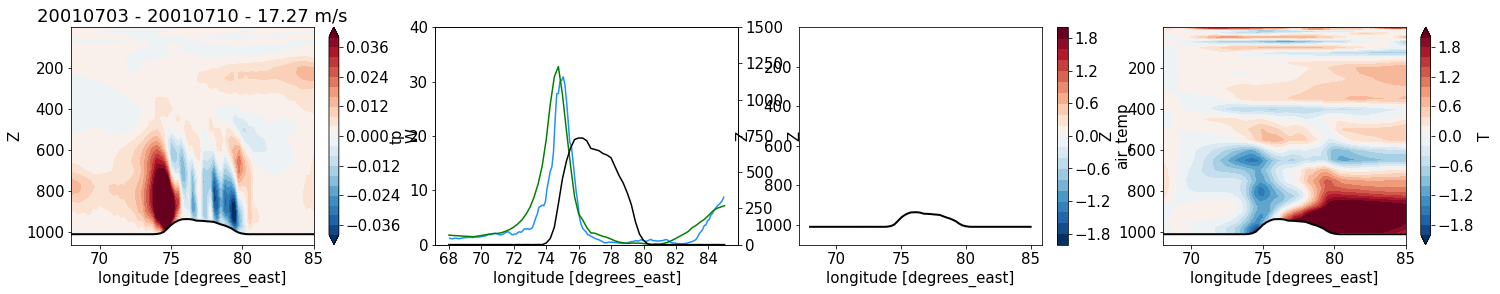

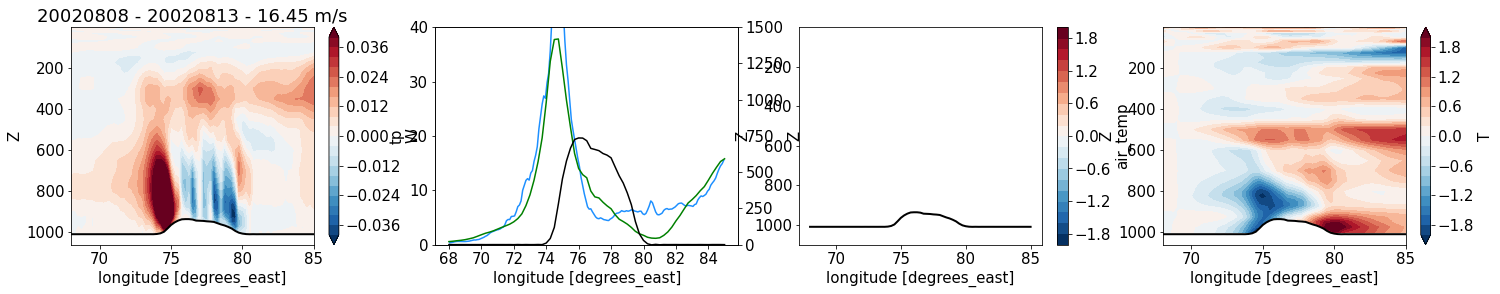

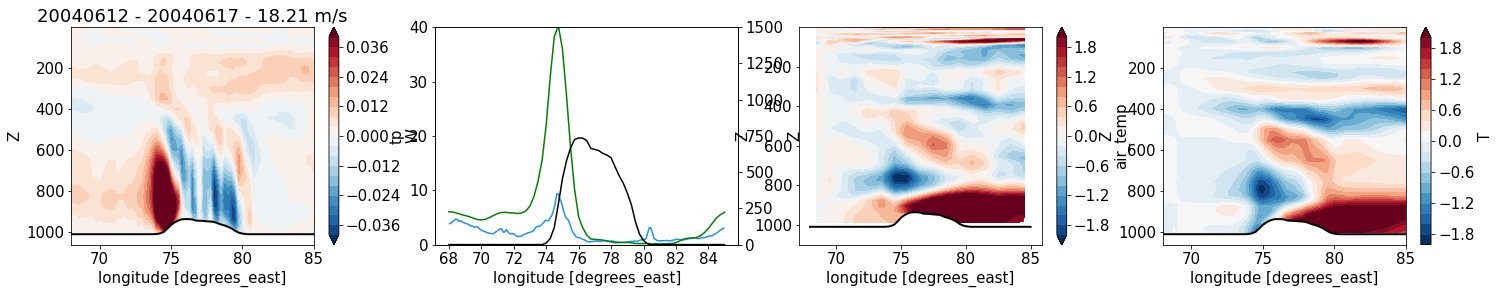

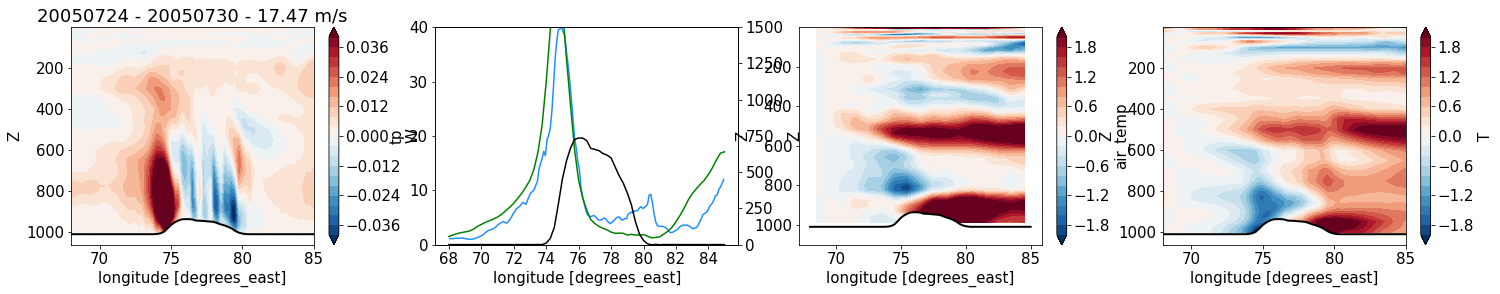

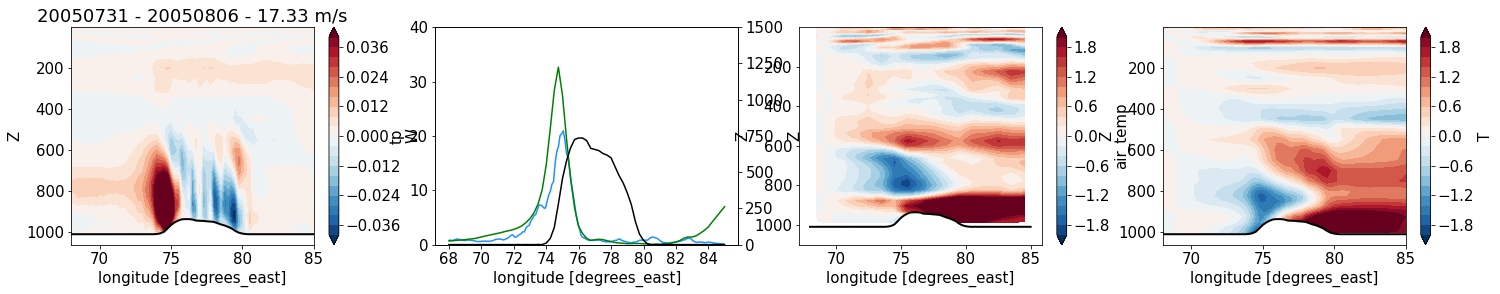

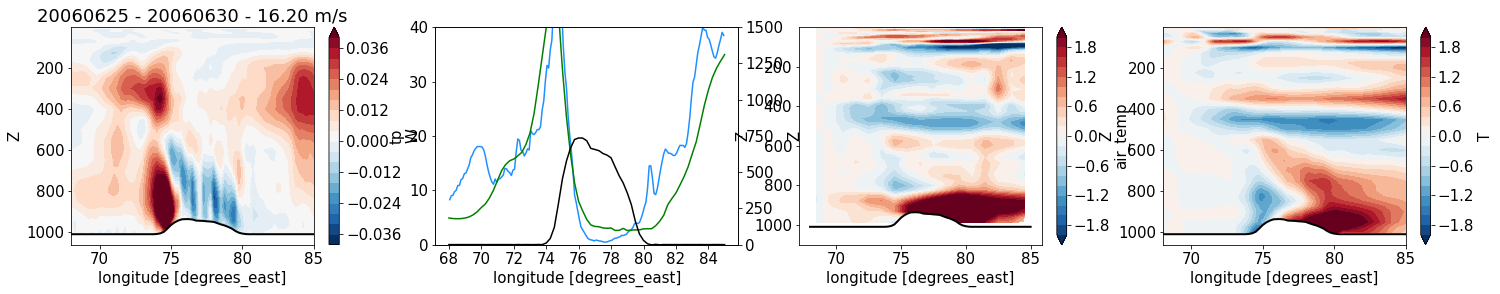

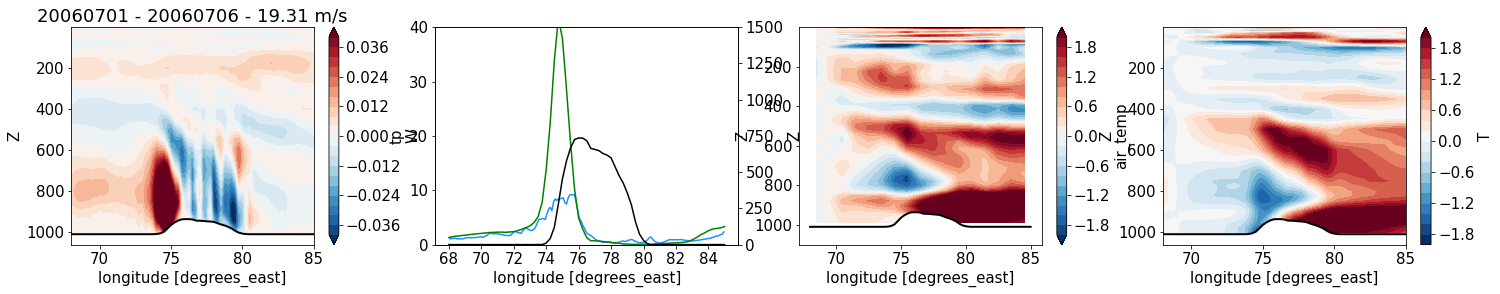

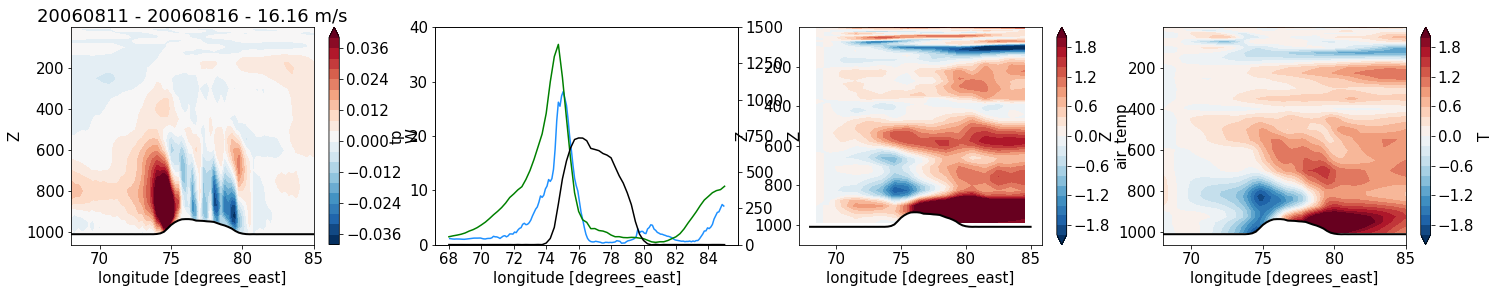

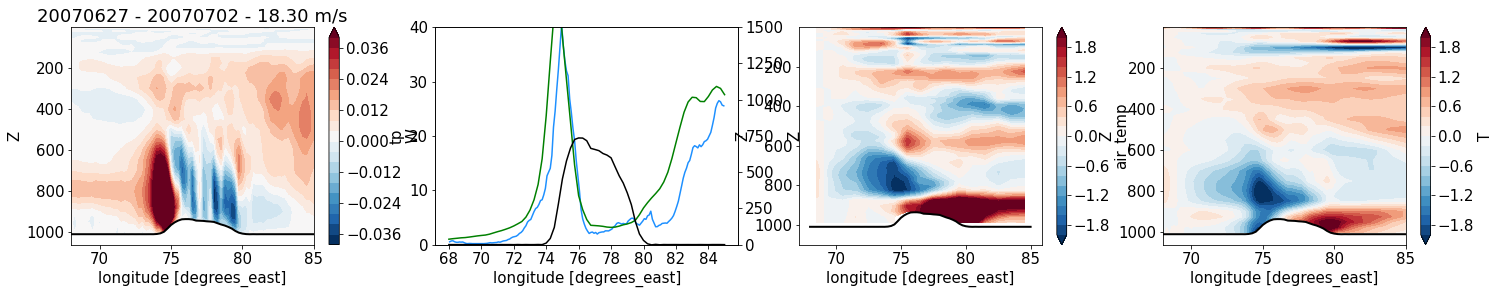

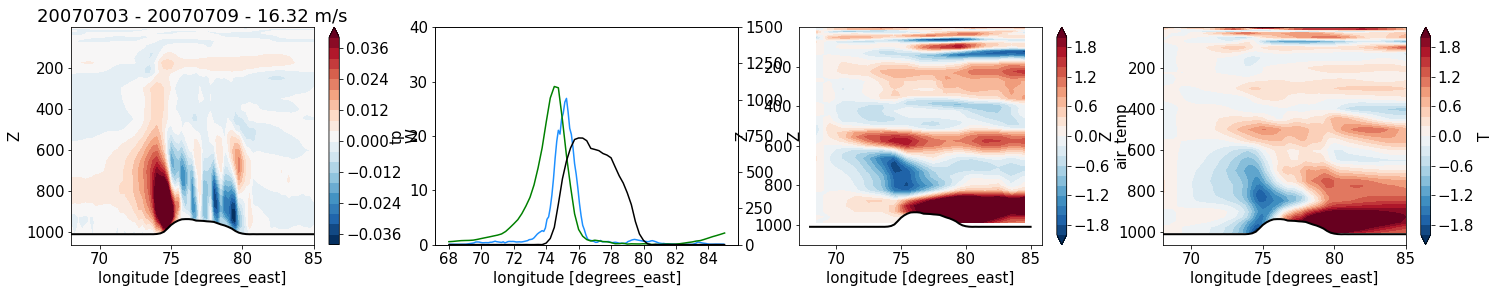

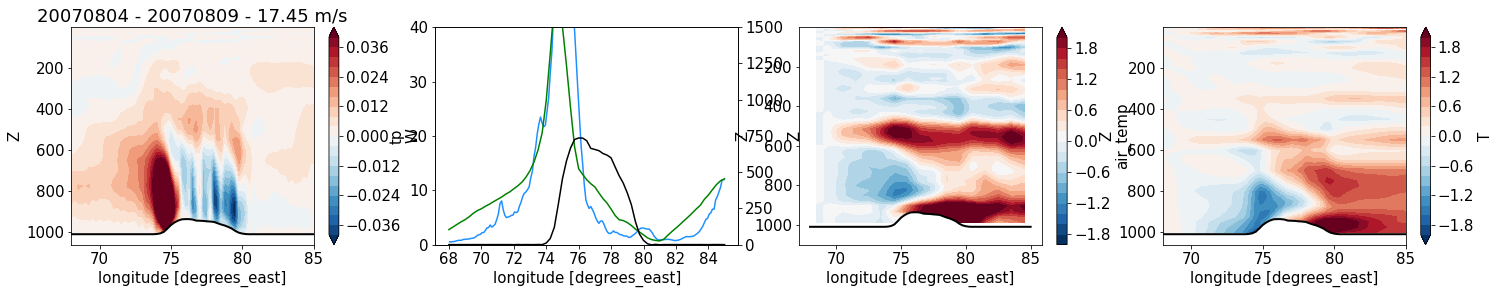

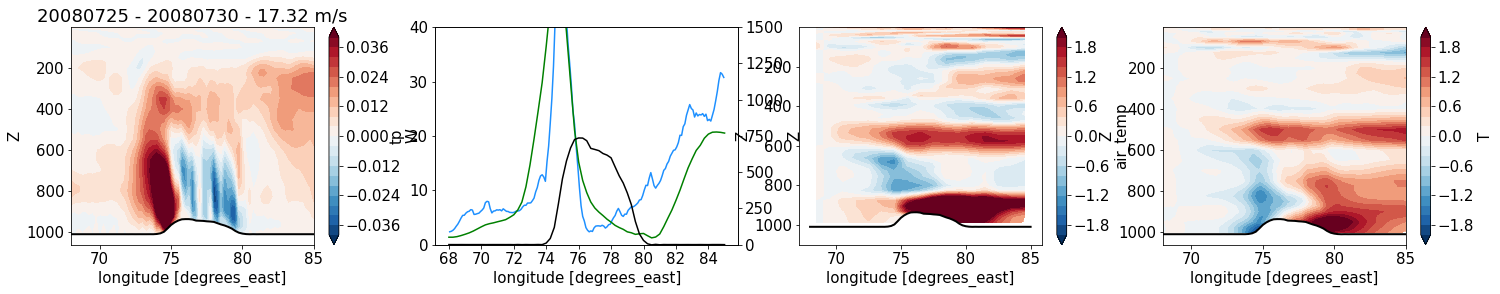

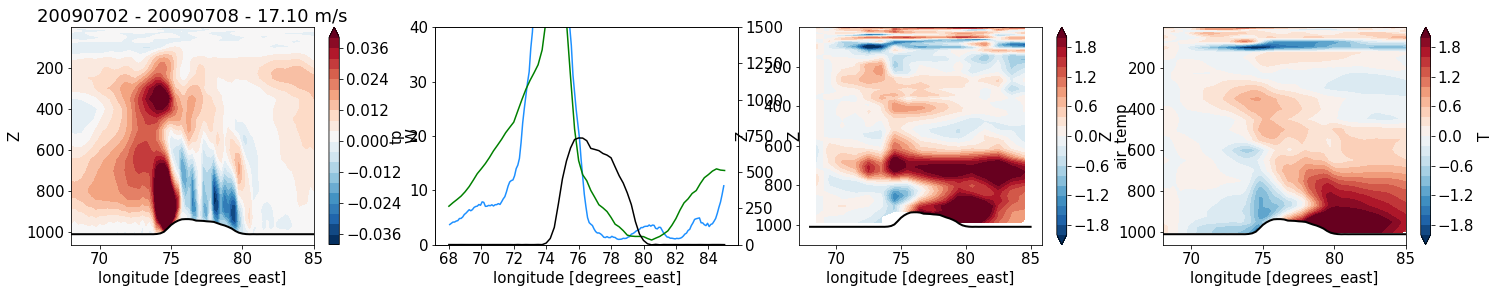

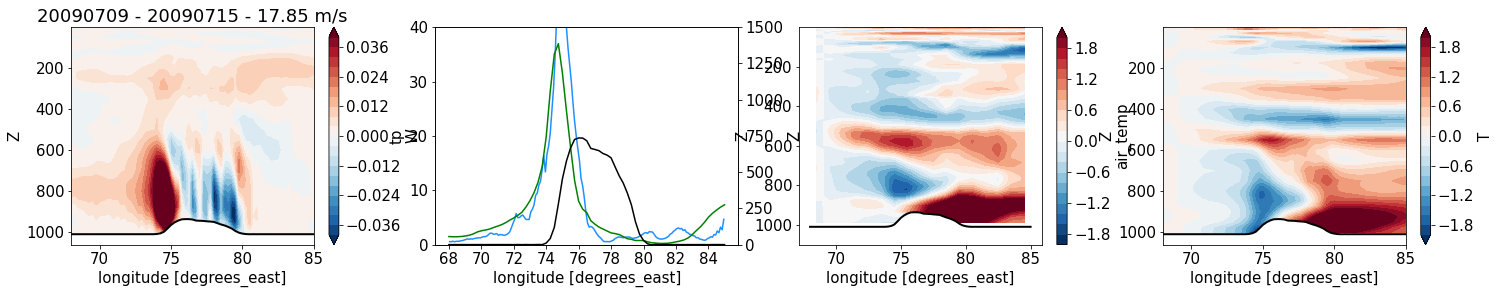

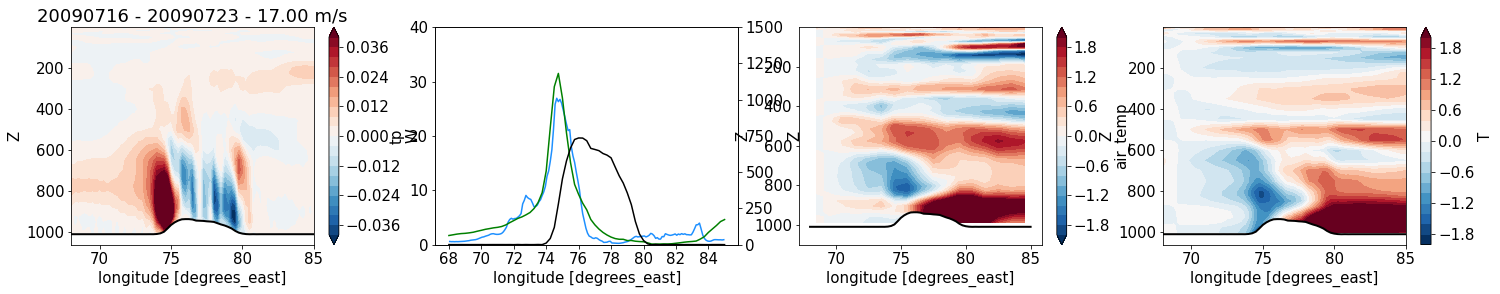

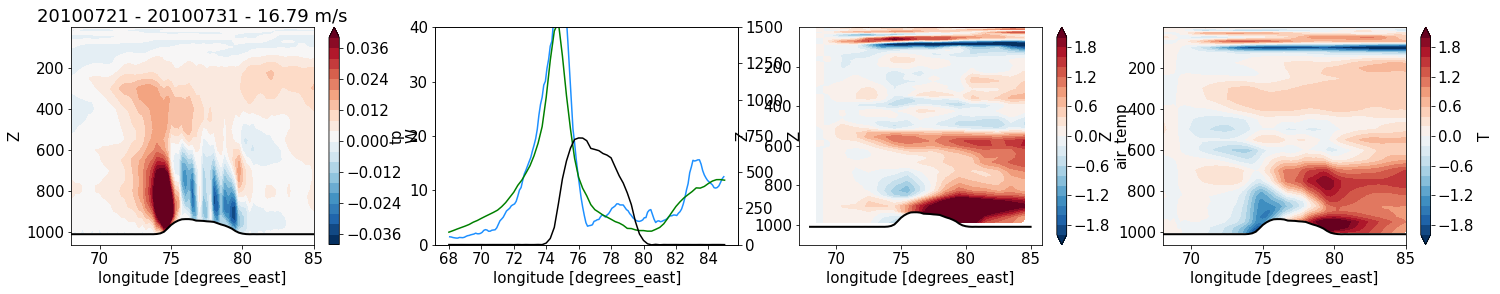

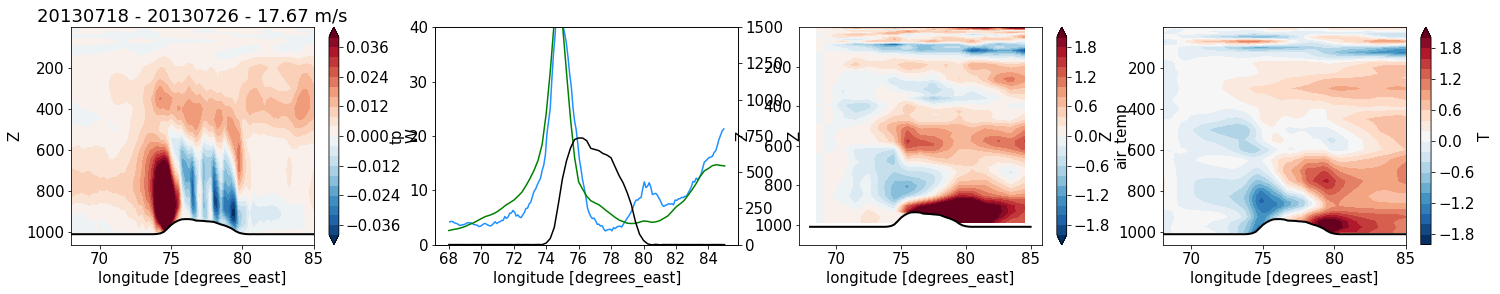

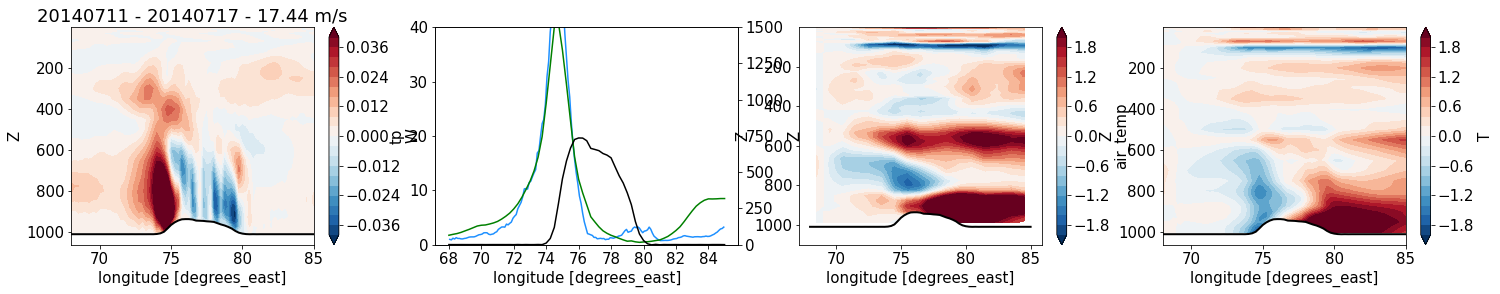

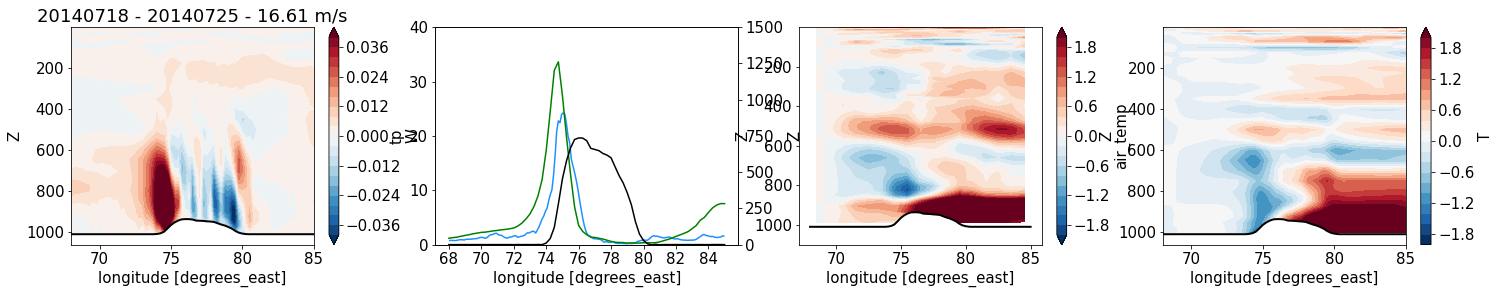

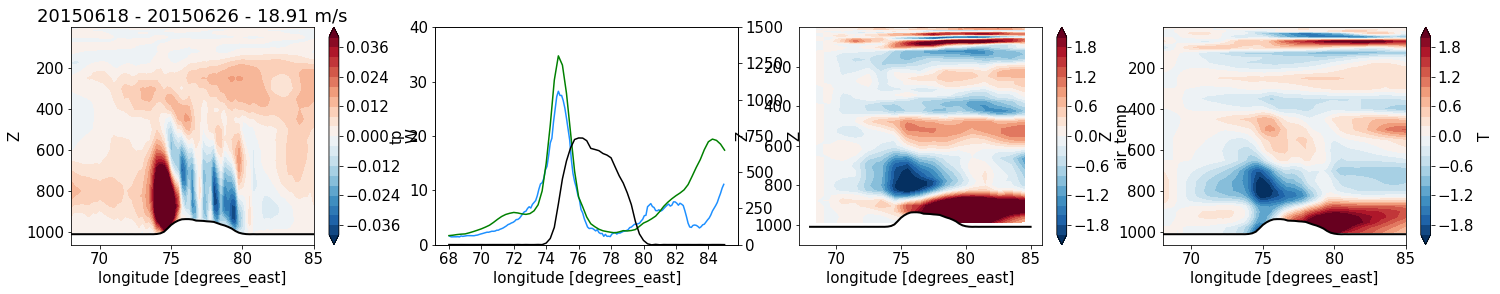

In [16]:
for i in range(nspells):
    days = np.array(uitg_upstream_daily[itgwindyspells_start[i]:itgwindyspells_end[i]].time)
    days_str = pd.to_datetime(days).strftime('%Y%m%d')
    
    era5w = era5w_ghatswide_jjahourly.sel(time=slice(days_str[0],days_str[-1])).sel(latitude=slice(15,13)).mean(['time','latitude']).load()
    era5t = era5t_ghatswide_jjahourly.sel(time=slice(days_str[0],days_str[-1])).sel(latitude=slice(15,13)).mean(['time','latitude']).load()
    era5tprime = era5t-era5t.sel(longitude=slice(68,70)).mean('longitude')
    era5pr = era5pr_ghatswide_hourly.sel(time=slice(days_str[0],days_str[-1])).mean(['time','latitude']).load()*(1000*24)
    gpmpr = gpmpr_ghatswide_jjadaily.sel(time=slice(days_str[0],days_str[-1])).sel(latitude=slice(15,13)).mean(['time','latitude']).load()
    
    airst = climcapst_ghatswide_jjadaily.sel(time=slice(days_str[0],days_str[-1])).sel(latitude=slice(15,13)).mean(['time','latitude']).load()
    airstprime=airst-airst.sel(longitude=slice(68,70)).mean('longitude')
    
    _,(ax1,ax2,ax3,ax4) = plt.subplots(1,4,figsize=(25,4))
    #W
    (-era5w/10).plot.contourf(ax=ax1,y='level',yincrease=False,levels=np.linspace(-0.04,0.04,21),cmap=plt.cm.RdBu_r)
    
    #PRECIPS
    gpmpr.plot(ax=ax2,label='GPM precip',color='dodgerblue')
    era5pr.plot(ax=ax2,label='ERA5 precip',color='g')
    ax22=ax2.twinx()
    ghatswide_topo.plot(ax=ax22,color='k')
    ax2.set_ylim(0,40)
    ax22.set_ylim(0,1500)
    ax2.set_xticks(np.arange(68,86,2));None
    
    #airs T
    airstprime.plot.contourf(ax=ax3,y='level',yincrease=False,levels=np.linspace(-2,2,21),cmap=plt.cm.RdBu_r)
    #ERA5 T
    era5tprime.plot.contourf(ax=ax4,y='level',yincrease=False,levels=np.linspace(-2,2,21),cmap=plt.cm.RdBu_r)

    for ax in (ax1,ax3,ax4):
        ax.fill_between(ghatswide_topo.longitude,1010*ghatswide_topo**0,1010-ghatswide_topo/10,color='w')
        (1010-ghatswide_topo/10).plot(ax=ax,color='k',linewidth=2)
    ax1.set_title(days_str[0]+" - "+days_str[-1]+ " - %.2f m/s"%(uitg_upstream_daily[itgwindyspells_start[i]:itgwindyspells_end[i]].mean('time')))
    ax22.set_title('');ax3.set_title('');ax4.set_title('')

In [21]:
itgwindyspells_start,itgwindyspells_end,itgwindyspells_lengths = get_subspells(uitg_upstream_daily>15,4)
nspells = len(itgwindyspells_start)

era5t_lowtrop_itgwindyspells = []
airst_lowtrop_itgwindyspells = []
era5tprime_lowtrop_itgwindyspells = []
airstprime_lowtrop_itgwindyspells = []
gpmpr_itgwindyspells = []

for i in range(nspells):
    days = np.array(uitg_upstream_daily[itgwindyspells_start[i]:itgwindyspells_end[i]].time)
    days_str = pd.to_datetime(days).strftime('%Y%m%d')
    
    era5t = era5t_ghatswide_jjahourly.sel(time=slice(days_str[0],days_str[-1])).sel(latitude=slice(15,13)).mean(['time','latitude']).load()
    era5tprime = era5t-era5t.sel(longitude=slice(68,70)).mean('longitude')

    airst = climcapst_ghatswide_jjadaily.sel(time=slice(days_str[0],days_str[-1])).sel(latitude=slice(15,13)).mean(['time','latitude']).load()
    airstprime=airst-airst.sel(longitude=slice(68,70)).mean('longitude')
     
    gpmpr = gpmpr_ghatswide_jjadaily.sel(time=slice(days_str[0],days_str[-1])).sel(latitude=slice(15,13)).mean(['time','latitude']).load()

    era5t_lowtrop_itgwindyspells.append( float(era5t.sel(longitude=slice(74,75),level=slice(700,900)).mean()))
    airst_lowtrop_itgwindyspells.append( float(airst.sel(longitude=slice(74,75),level=slice(700,900)).mean()))
    era5tprime_lowtrop_itgwindyspells.append( float(era5tprime.sel(longitude=slice(74,75),level=slice(700,900)).mean()))
    airstprime_lowtrop_itgwindyspells.append( float(airstprime.sel(longitude=slice(74,75),level=slice(700,900)).mean()))
    gpmpr_itgwindyspells.append( float(gpmpr.sel(longitude=slice(74,75)).mean()))
       

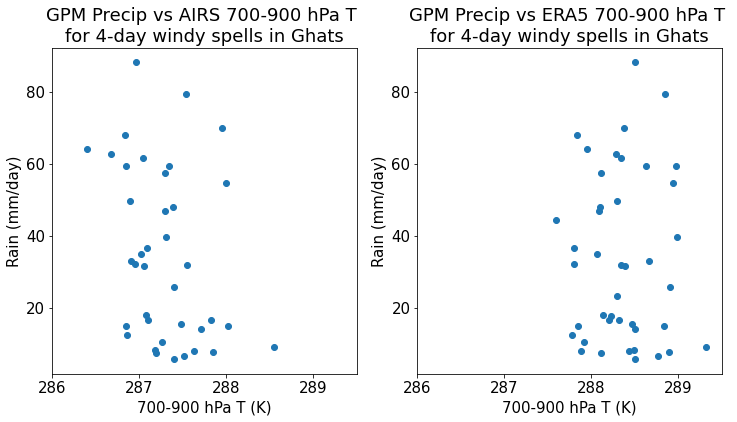

In [22]:
_,(ax1,ax2)=plt.subplots(1,2,figsize=(12,6))
#plt.plot([0,50],[0,50],color='r')
ax1.scatter(airst_lowtrop_itgwindyspells,gpmpr_itgwindyspells)
ax1.set_title('GPM Precip vs AIRS 700-900 hPa T \nfor 4-day windy spells in Ghats')

ax2.scatter(era5t_lowtrop_itgwindyspells,gpmpr_itgwindyspells)
ax2.set_title('GPM Precip vs ERA5 700-900 hPa T \nfor 4-day windy spells in Ghats')
for ax in ax1,ax2:
    ax.set_xlabel('700-900 hPa T (K)')
    ax.set_ylabel('Rain (mm/day)')
    ax.set_xlim(286,289.5)

In [16]:
era5t_long = era5t_ghatswide_jjahourly.sel(latitude=slice(15,13),level=slice(700,900)).mean(['latitude','level']).load().coarsen(time=24).mean()
era5t = era5t_long.sel(longitude=slice(74,75)).mean('longitude')
era5tprime = era5t-era5t_long.sel(longitude=slice(68,70)).mean('longitude')

airst_long = climcapst_ghatswide_jjadaily.sel(latitude=slice(15,13),level=slice(700,900)).mean(['latitude','level']).load().coarsen(time=2).mean()
airst=airst_long.sel(longitude=slice(74,75)).mean('longitude')
airstprime=airst-airst_long.sel(longitude=slice(68,70)).mean('longitude')
 
gpmpr = gpmpr_ghatswide_jjadaily.sel(latitude=slice(15,13),longitude=slice(74,75)).mean(['latitude','longitude']).load()



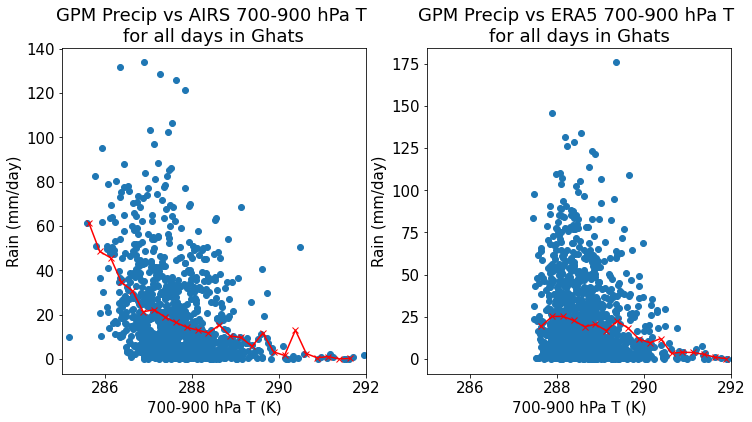

In [17]:
_,(ax1,ax2)=plt.subplots(1,2,figsize=(12,6))
#plt.plot([0,50],[0,50],color='r')
t,p=airst.sel(time=slice("2002-08-30","2015-08-30")),gpmpr.sel(time=slice("2002-08-30","2015-08-30"))
ax1.scatter(t,p)
ax1.plot(*get_binned(t,p,np.arange(285.5,292.1,0.25)),'-rx')
ax1.set_title('GPM Precip vs AIRS 700-900 hPa T \nfor all days in Ghats')

ax2.scatter(era5t,gpmpr)
ax2.plot(*get_binned(era5t,gpmpr,np.arange(287,292.1,0.25)),'-rx')
ax2.set_title('GPM Precip vs ERA5 700-900 hPa T \nfor all days in Ghats')
for ax in ax1,ax2:
    ax.set_xlabel('700-900 hPa T (K)')
    ax.set_ylabel('Rain (mm/day)')
    ax.set_xlim(285,292)

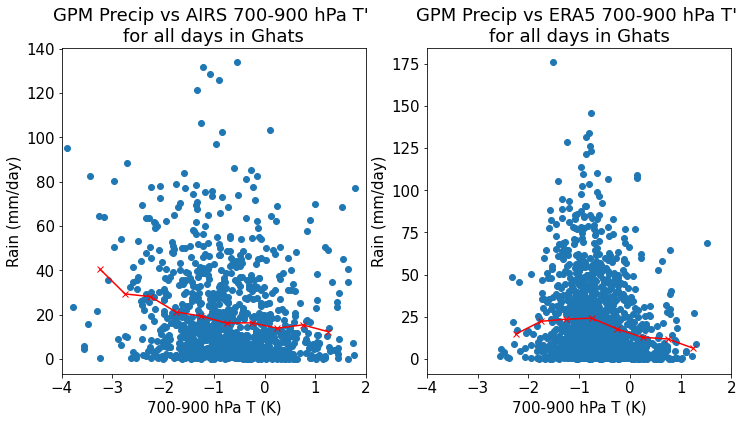

In [158]:
_,(ax1,ax2)=plt.subplots(1,2,figsize=(12,6))
#plt.plot([0,50],[0,50],color='r')
t,p=airstprime.sel(time=slice("2002-08-30","2015-08-30")),gpmpr.sel(time=slice("2002-08-30","2015-08-30"))
ax1.scatter(t,p)
ax1.plot(*get_binned(t,p,np.arange(-4,2.1,0.5)),'-rx')
ax1.set_title("GPM Precip vs AIRS 700-900 hPa T' \nfor all days in Ghats")

ax2.scatter(era5tprime,gpmpr)
ax2.plot(*get_binned(era5tprime,gpmpr,np.arange(-4,2.1,0.5)),'-rx')
ax2.set_title("GPM Precip vs ERA5 700-900 hPa T' \nfor all days in Ghats")
for ax in ax1,ax2:
    ax.set_xlabel('700-900 hPa T (K)')
    ax.set_ylabel('Rain (mm/day)')
    ax.set_xlim(-4,2)

Text(0.5, 1.0, '20150618 - 20150626 - 18.91 m/s')

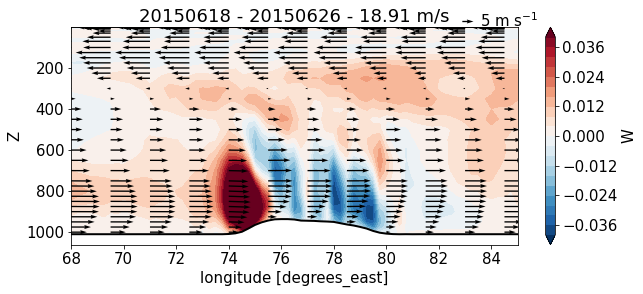

In [36]:
i=-1
days = np.array(uitg_upstream_daily[itgwindyspells_start[i]:itgwindyspells_end[i]].time)
days_str = pd.to_datetime(days).strftime('%Y%m%d')

era5w = era5w_ghatswide_jjahourly.sel(time=slice(days_str[0],days_str[-1])).sel(latitude=slice(15,13)).mean(['time','latitude']).load()
era5u = era5u_ghatswide_jjahourly.sel(time=slice(days_str[0],days_str[-1])).sel(latitude=slice(15,13)).mean(['time','latitude']).load()

_,ax1 = plt.subplots(1,1,figsize=(10,4))
#W
(-era5w/10).plot.contourf(ax=ax1,y='level',yincrease=False,levels=np.linspace(-0.04,0.04,21),cmap=plt.cm.RdBu_r)

u,v=era5u,era5w
X = u.level.expand_dims({"longitude":u.longitude}).transpose()
Y = u.longitude.expand_dims({"level":u.level})
n=len(u.level)//20
m=len(u.longitude)//10
q=ax1.quiver(np.array(Y)[::n,::m],np.array(X)[::n,::m], np.array(u)[::n,::m], np.array(v)[::n,::m],color="k",width=0.003,scale=400)
qk = ax1.quiverkey(q, 0.9, 1.03, 10, r'5 m s$^{-1}$', labelpos='E',
                       coordinates='axes',color='k')

for ax in (ax1,):
    ax.fill_between(ghatswide_topo.longitude,1010*ghatswide_topo**0,1010-ghatswide_topo/10,color='w')
    (1010-ghatswide_topo/10).plot(ax=ax,color='k',linewidth=2)
ax1.set_title(days_str[0]+" - "+days_str[-1]+ " - %.2f m/s"%(uitg_upstream_daily[itgwindyspells_start[i]:itgwindyspells_end[i]].mean('time')))



# Full BL treatment: all days & specific case studies

## All days

In [2]:
import metpy.calc as mpcalc

In [18]:
def BL_plevs_vectorized(t,q,p,lft_top_pressure):
    t_dew = mpcalc.dewpoint_from_specific_humidity(np.array(q), np.array(t)*units.K, np.array(p)*units.hPa)
    zero_array = 0.*t
    thetae = zero_array+np.array(mpcalc.equivalent_potential_temperature(np.array(p)*units.hPa,
                                                                         np.array(t)*units.K,
                                                                         t_dew
                                                                        )/units.K)
    thetaestar = zero_array+np.array(mpcalc.saturation_equivalent_potential_temperature(np.array(p)*units.hPa,
                                                                                        np.array(t)*units.K
                                                                                       )/units.K)
    
    kappaL=3
    g=9.81
    wB = 0.52
    wL = 1-wB
    thetae0 = 340
    
    if np.sum(np.array(t.shape)==37)==0:
        print('shit')
        print(t.shape)
    pres_axis=np.argmax(np.array(t.shape)==37)
    thetaeB     = np.nanmean(np.where( p>=900                         ,thetae    ,np.nan),axis=pres_axis)
    thetaeL     = np.nanmean(np.where((p< 900.) & (p>lft_top_pressure),thetae    ,np.nan),axis=pres_axis)
    thetaeLstar = np.nanmean(np.where((p< 900.) & (p>lft_top_pressure),thetaestar,np.nan),axis=pres_axis)
    
    capeL   = (thetaeB/thetaeLstar - 1)*thetae0
    subsatL = (1 - thetaeL/thetaeLstar)*thetae0
    BL = g/kappaL/thetae0*(wB*capeL-wL*subsatL)

    return BL

def BL_plevs(t,q,lft_top_pressure,pname='level'):
    p = t**0*t[pname]
    t_dew = mpcalc.dewpoint_from_specific_humidity(np.array(q), np.array(t)*units.K, np.array(p)*units.hPa)
    zero_array = 0.*p
    thetae = zero_array+np.array(mpcalc.equivalent_potential_temperature(np.array(p)*units.hPa,
                                                                         np.array(t)*units.K,
                                                                         t_dew
                                                                        )/units.K)
    thetaestar = zero_array+np.array(mpcalc.saturation_equivalent_potential_temperature(np.array(p)*units.hPa,
                                                                                        np.array(t)*units.K
                                                                                       )/units.K)
    kappaL=3
    g=9.81
    wB = 0.52
    wL = 1-wB
    thetae0 = 340

    thetaeB     = thetae    .where( p>=900                         ).mean(pname)
    thetaeL     = thetae    .where((p< 900.) & (p>lft_top_pressure)).mean(pname)
    thetaeLstar = thetaestar.where((p< 900.) & (p>lft_top_pressure)).mean(pname)
    
    capeL   = (thetaeB/thetaeLstar - 1)*thetae0
    subsatL = (1 - thetaeL/thetaeLstar)*thetae0
    BL = g/kappaL/thetae0*(wB*capeL-wL*subsatL)
    return BL

In [4]:
era5t_ghats_julhourly = xr.concat((xr.open_zarr("/global/cscratch1/sd/qnicolas/regionsData/e5.oper.an.pl.128_130_t.ll025sc.%i%s.ghats.zarr"%(year,month)) for year,month in itertools.product(range(2001,2015),('07',))),dim='time').T
era5q_ghats_julhourly = xr.concat((xr.open_zarr("/global/cscratch1/sd/qnicolas/regionsData/e5.oper.an.pl.128_133_q.ll025sc.%i%s.ghats.zarr"%(year,month)) for year,month in itertools.product(range(2001,2015),('07',))),dim='time').Q


In [5]:
era5t_all = era5t_ghats_julhourly
era5q_all = era5q_ghats_julhourly

In [27]:
%%time 
ntimes=len(era5t_all.time)
BL = xr.apply_ufunc(lambda t,q,p: BL_plevs_vectorized(t,q,p,700.),
                    era5t_all[:ntimes],
                    era5q_all[:ntimes],
                    (era5t_all[:ntimes]**0*era5t_all.level),
                    input_core_dims=[['level'],['level'],['level']],
                    vectorize=False,
                    dask='parallelized',
                    output_dtypes=[np.float64]).load()

#input_core_dims=[['time','level'],['time','level']],
#output_core_dims=[['time']],
#output_sizes={'time':ntimes},
                    

shit
(0, 0, 0, 0)


/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/pint/numpy_func.py:289: RuntimeWarning: invalid value encountered in log
  result_magnitude = func(*stripped_args, **stripped_kwargs)
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/pint/quantity.py:1393: RuntimeWarning: invalid value encountered in power
  return other ** new_self._magnitude
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/metpy/calc/thermo.py:1067: RuntimeWarning: overflow encountered in exp
  th_es = th_l * np.exp((3036. / t - 1.78) * r * (1 + 0.448 * r))
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/metpy/calc/thermo.py:1067: RuntimeWarning: overflow encountered in multiply
  th_es = th_l * np.exp((3036. / t - 1.78) * r * (1 + 0.448 * r))


CPU times: user 11min 49s, sys: 1min 6s, total: 12min 55s
Wall time: 49.7 s


In [22]:
%%time 
pr = xr.open_mfdataset("/global/cscratch1/sd/qnicolas/regionsData/e5.oper.an.sfc.128_228_tp.ll025sc.*.ghatswide.nc").tp
pr= pr.sel(time=((pr['time.month']==7)&(pr['time.year']<=2014))).load()*24*1000


CPU times: user 835 ms, sys: 388 ms, total: 1.22 s
Wall time: 621 ms


### Scatterplots

/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice.
  """
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice.
  """
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


CPU times: user 25.8 s, sys: 14 s, total: 39.8 s
Wall time: 39.7 s


Text(0.5, 1.0, 'ERA5 Precip vs ERA5 BL \nfor all July days around Ghats')

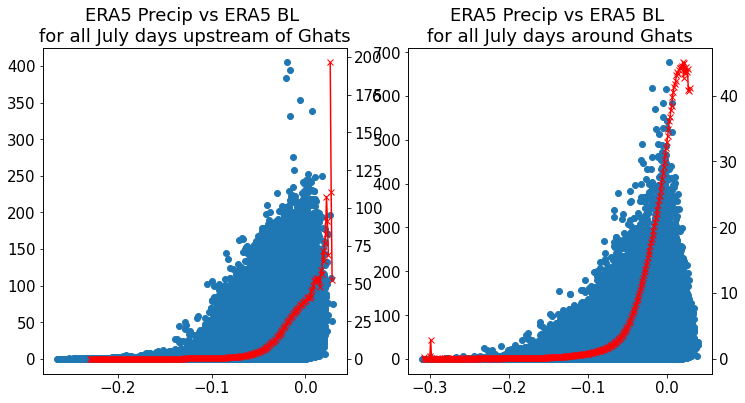

In [25]:
%%time
_,(ax1,ax2)=plt.subplots(1,2,figsize=(12,6))

ax12=ax1.twinx()
ax1.scatter(BL.sel(latitude=slice(17,10),longitude=slice(69,73)),
            pr.sel(latitude=slice(17,10),longitude=slice(69,73)))
ax12.plot(*get_binned(BL.sel(latitude=slice(17,10),longitude=slice(69,73)),
                      pr.sel(latitude=slice(17,10),longitude=slice(69,73)),
                      np.arange(-0.23,0.04,0.001)),'-rx')
ax1.set_title('ERA5 Precip vs ERA5 BL \nfor all July days upstream of Ghats')

ax22=ax2.twinx()
ax2.scatter(BL,pr.sel(longitude=slice(68,80)))
ax22.plot(*get_binned(BL,pr.sel(longitude=slice(68,80)),np.arange(-0.31,0.03,0.001)),'-rx')
ax2.set_title('ERA5 Precip vs ERA5 BL \nfor all July days around Ghats')



In [55]:
BL_lft = (-1004*era5t_all/3/3600 + 2.5e6*era5q_all/11/3600).sel(level=slice(700.,900.)).mean('level').load()
BL_lft = BL_lft-BL_lft.sel(latitude=13,longitude=68).mean()

In [56]:
BL_lft = BL_lft/2.5e6*8000*86400/2.5

CPU times: user 7.54 s, sys: 2.56 s, total: 10.1 s
Wall time: 10.1 s


Text(0.5, 1.0, 'ERA5 Precip vs ERA5 BL_LFT \nfor all July days around Ghats')

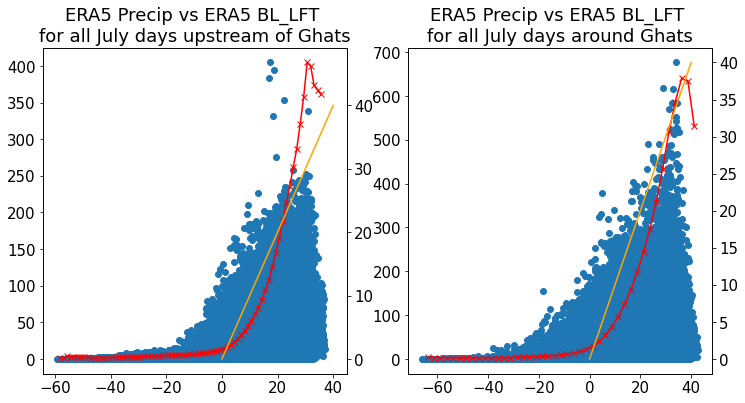

In [60]:
%%time
_,(ax1,ax2)=plt.subplots(1,2,figsize=(12,6))

ax12=ax1.twinx()
ax1.scatter(BL_lft.sel(latitude=slice(17,10),longitude=slice(69,73)),
            pr.sel(latitude=slice(17,10),longitude=slice(69,73)))
ax12.plot(*get_binned(BL_lft.sel(latitude=slice(17,10),longitude=slice(69,73)),
                      pr.sel(latitude=slice(17,10),longitude=slice(69,73)),
                      np.arange(-75,50,1.25)),'-rx')
ax12.plot([0,40],[0,40],color='orange')

ax1.set_title('ERA5 Precip vs ERA5 BL_LFT \nfor all July days upstream of Ghats')

ax22=ax2.twinx()
ax2.scatter(BL_lft,pr.sel(longitude=slice(68,80)))
ax22.plot(*get_binned(BL_lft,pr.sel(longitude=slice(68,80)),np.arange(-150,100,2.5)),'-rx')
ax22.plot([0,40],[0,40],color='orange')

ax2.set_title('ERA5 Precip vs ERA5 BL_LFT \nfor all July days around Ghats')



### Profiles

In [69]:
%%time 
gpmpr_jul = xr.open_zarr("/global/cscratch1/sd/qnicolas/regionsData/gpm_imerg_v06.2001-2015.07.ghatswide.zarr").precipitationCal
gpmpr_jul= gpmpr_jul.sel(time=(gpmpr_jul['time.year']<=2014))


CPU times: user 36.2 ms, sys: 11 ms, total: 47.1 ms
Wall time: 62.1 ms


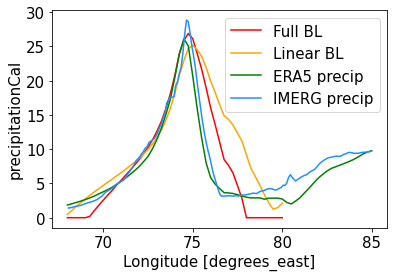

In [90]:
BLprof=BL.sel(latitude=slice(15,13)).mean(('latitude','time')).load()
np.maximum((BLprof+0.07)*480,0.).plot(label = "Full BL",color='r')
BL_lft.sel(latitude=slice(15,13)).mean(('latitude','time')).plot(label = "Linear BL",color='orange')
pr.sel(latitude=slice(15,13)).mean(('latitude','time')).plot(label = "ERA5 precip",color='g')
gpmpr_jul.sel(latitude=slice(15,13)).mean(('latitude','time')).plot(label = "IMERG precip",color='dodgerblue')
plt.legend()

## Case studies

Text(0.5, 1.0, '20140715 to 20140725')

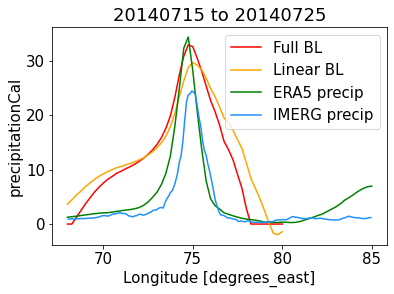

In [91]:
time0 = "20140715"
time1 = "20140725"
times=slice(time0,time1)
BLprof=BL.sel(latitude=slice(15,13),time=times).mean(('latitude','time')).load()
np.maximum((BLprof+0.07)*480,0.).plot(label = "Full BL",color='r')
BL_lft.sel(latitude=slice(15,13),time=times).mean(('latitude','time')).plot(label = "Linear BL",color='orange')
pr.sel(latitude=slice(15,13),time=times).mean(('latitude','time')).plot(label = "ERA5 precip",color='g')
gpmpr_jul.sel(latitude=slice(15,13),time=times).mean(('latitude','time')).plot(label = "IMERG precip",color='dodgerblue')
plt.legend()
plt.title(time0+' to '+time1)

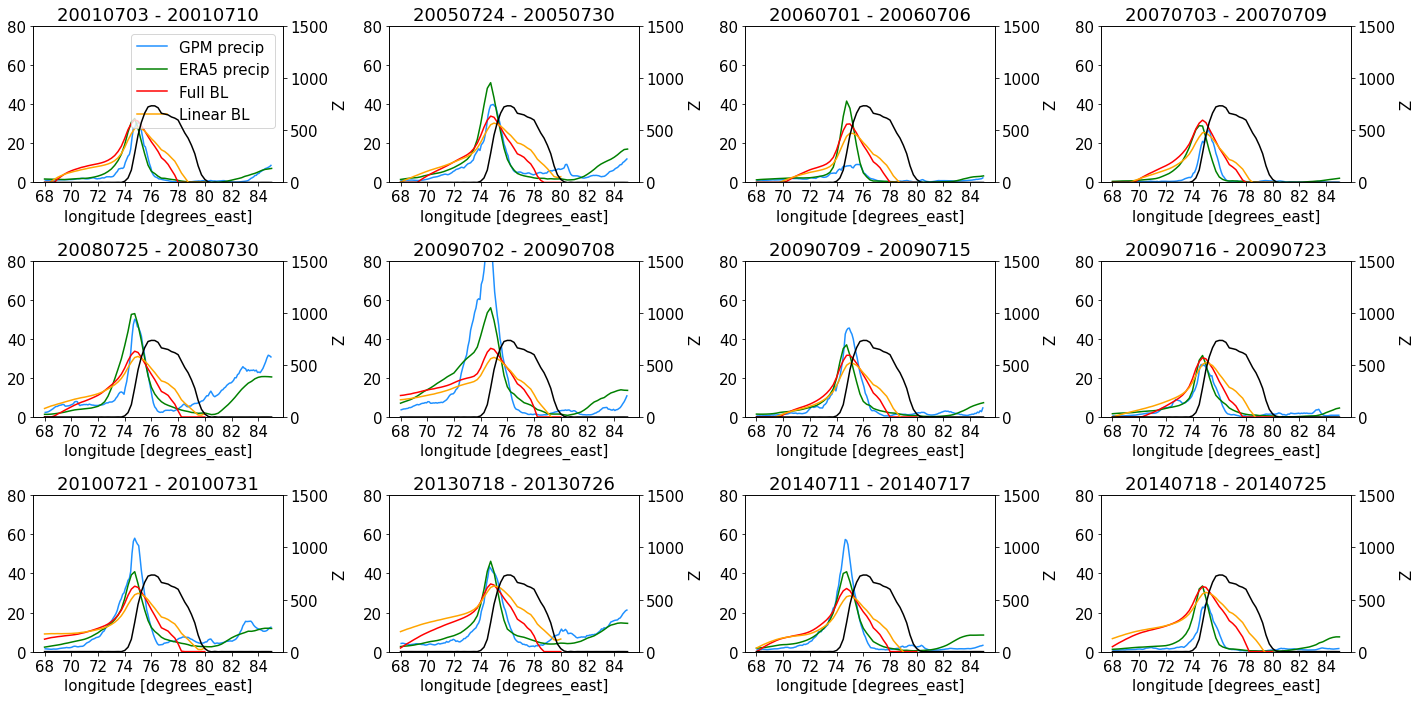

In [94]:
fig,axs = plt.subplots(3,4,figsize=(20,10))
axs=axs.reshape(-1)
i=-1
for j in range(nspells):
    days = np.array(uitg_upstream_daily[itgwindyspells_start[j]:itgwindyspells_end[j]].time)
    days_str = pd.to_datetime(days).strftime('%Y%m%d')
    if days_str[0][-4:-2]!='07' or days_str[-1][-4:-2]!='07':
        continue
    i+=1
    ax=axs[i]

    era5pr = pr.sel(latitude=slice(15,13),time=slice(days_str[0],days_str[-1])).mean(['time','latitude']).load()
    gpmpr = gpmpr_jul.sel(latitude=slice(15,13),time=slice(days_str[0],days_str[-1])).mean(['time','latitude']).load()

    #PRECIPS
    gpmpr.plot(ax=ax,label='GPM precip',color='dodgerblue')
    era5pr.plot(ax=ax,label='ERA5 precip',color='g')
    
    BLprof=BL.sel(latitude=slice(15,13),time=slice(days_str[0],days_str[-1])).mean(('latitude','time')).load()
    np.maximum((BLprof+0.07)*480,0.).plot(ax=ax,label = "Full BL",color='r')
    BL_lft.sel(latitude=slice(15,13),time=slice(days_str[0],days_str[-1])).mean(('latitude','time')).plot(ax=ax,label = "Linear BL",color='orange')
    
    
    ax2=ax.twinx()
    ghatswide_topo.plot(ax=ax2,color='k')
    ax.set_ylim(0,80)
    ax2.set_ylim(0,1500)
    ax.set_xticks(np.arange(68,86,2));None

    ax.set_title(days_str[0]+" - "+days_str[-1])
    ax2.set_title("")
    if i==0:
        ax.legend()
fig.tight_layout()

# Figures for Chris & Joan, x-y Temperature maps, soundings

distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker


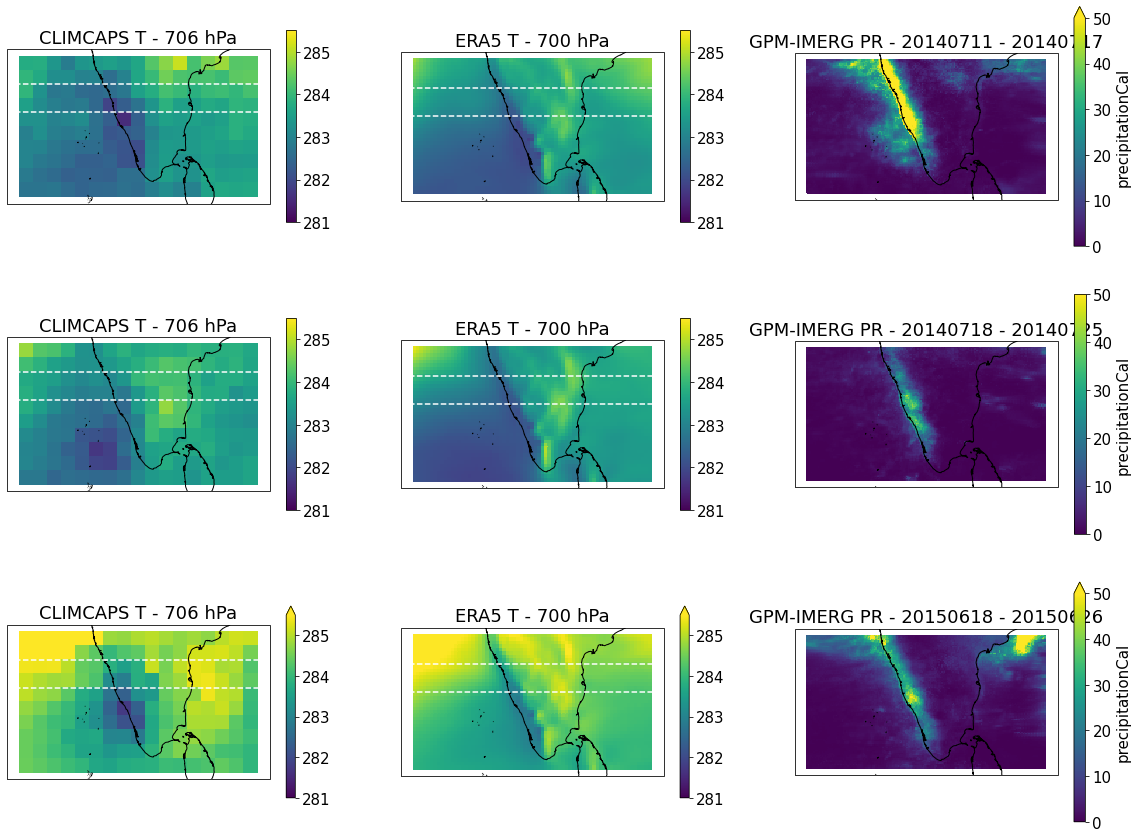

In [113]:

fig = plt.figure(figsize=(20,15))
spec = gridspec.GridSpec(nrows=3, ncols=3,figure=fig)

for j,i in enumerate([-3,-2,-1]):
    ax1 = fig.add_subplot(spec[3*j+0],projection= ccrs.PlateCarree())
    ax2 = fig.add_subplot(spec[3*j+1],projection= ccrs.PlateCarree())
    ax3 = fig.add_subplot(spec[3*j+2],projection= ccrs.PlateCarree())
    days = np.array(uitg_upstream_daily[itgwindyspells_start[i]:itgwindyspells_end[i]].time)
    days_str = pd.to_datetime(days).strftime('%Y%m%d')
    
    era5t_map = era5t_ghatswide_jjahourly.sel(time=slice(days_str[0],days_str[-1])).sel(level=700.).mean(['time']).load()
    airst_map = climcapst_ghatswide_jjadaily.sel(time=slice(days_str[0],days_str[-1])).sel(level=700.,method='nearest').mean(['time']).load()
    gpmpr_map = gpmpr_ghatswide_jjadaily.sel(time=slice(days_str[0],days_str[-1])).mean(['time']).load().transpose()
    
    
    #airs T
    airst_map.plot(ax=ax1,transform=ccrs.PlateCarree(),vmin=281,vmax=285.5,cbar_kwargs={'shrink':0.8,'label':''})   
    #ERA5 T
    era5t_map.plot(ax=ax2,transform=ccrs.PlateCarree(),vmin=281,vmax=285.5,cbar_kwargs={'shrink':0.8,'label':''})
    #AIRS T'
    gpmpr_map.plot(ax=ax3,transform=ccrs.PlateCarree(),vmin=0.,vmax=50.)

    ax1.set_title("CLIMCAPS T - %i hPa"%airst_map.level)
    ax2.set_title("ERA5 T - 700 hPa")        
    ax1.coastlines();ax2.coastlines();ax3.coastlines()
    ax1.axhline(13,color='w',linestyle='--');ax1.axhline(15,color='w',linestyle='--')
    ax2.axhline(13,color='w',linestyle='--');ax2.axhline(15,color='w',linestyle='--')
    ax3.set_title("GPM-IMERG PR - "+days_str[0]+" - "+days_str[-1])

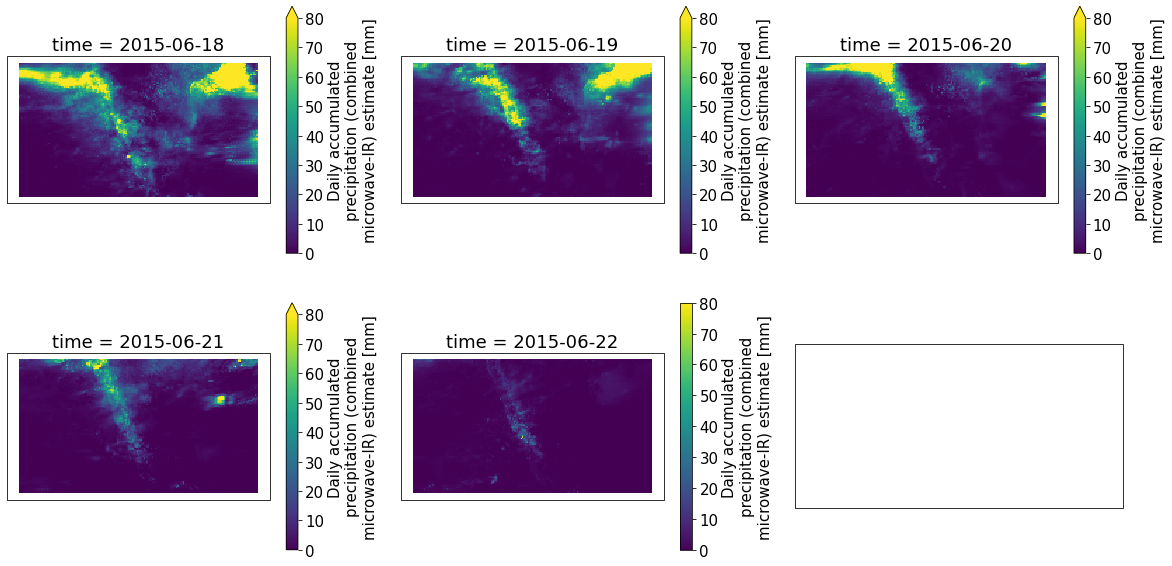

In [117]:
fig,axs = plt.subplots(2,3,figsize=(20,10),subplot_kw={'projection': ccrs.PlateCarree()})
axs = axs.reshape(-1)
i=-1
for day,ax in zip(range(itgwindyspells_start[i],itgwindyspells_end[i]),axs[:-1]):
    day = np.array(uitg_upstream_daily[day].time)
    day_str = pd.to_datetime(day).strftime('%Y%m%d')
    gpmpr_map = gpmpr_ghatswide_jjadaily.sel(time=day_str).load().transpose()
    gpmpr_map.plot(ax=ax,transform=ccrs.PlateCarree(),vmin=0.,vmax=80.)

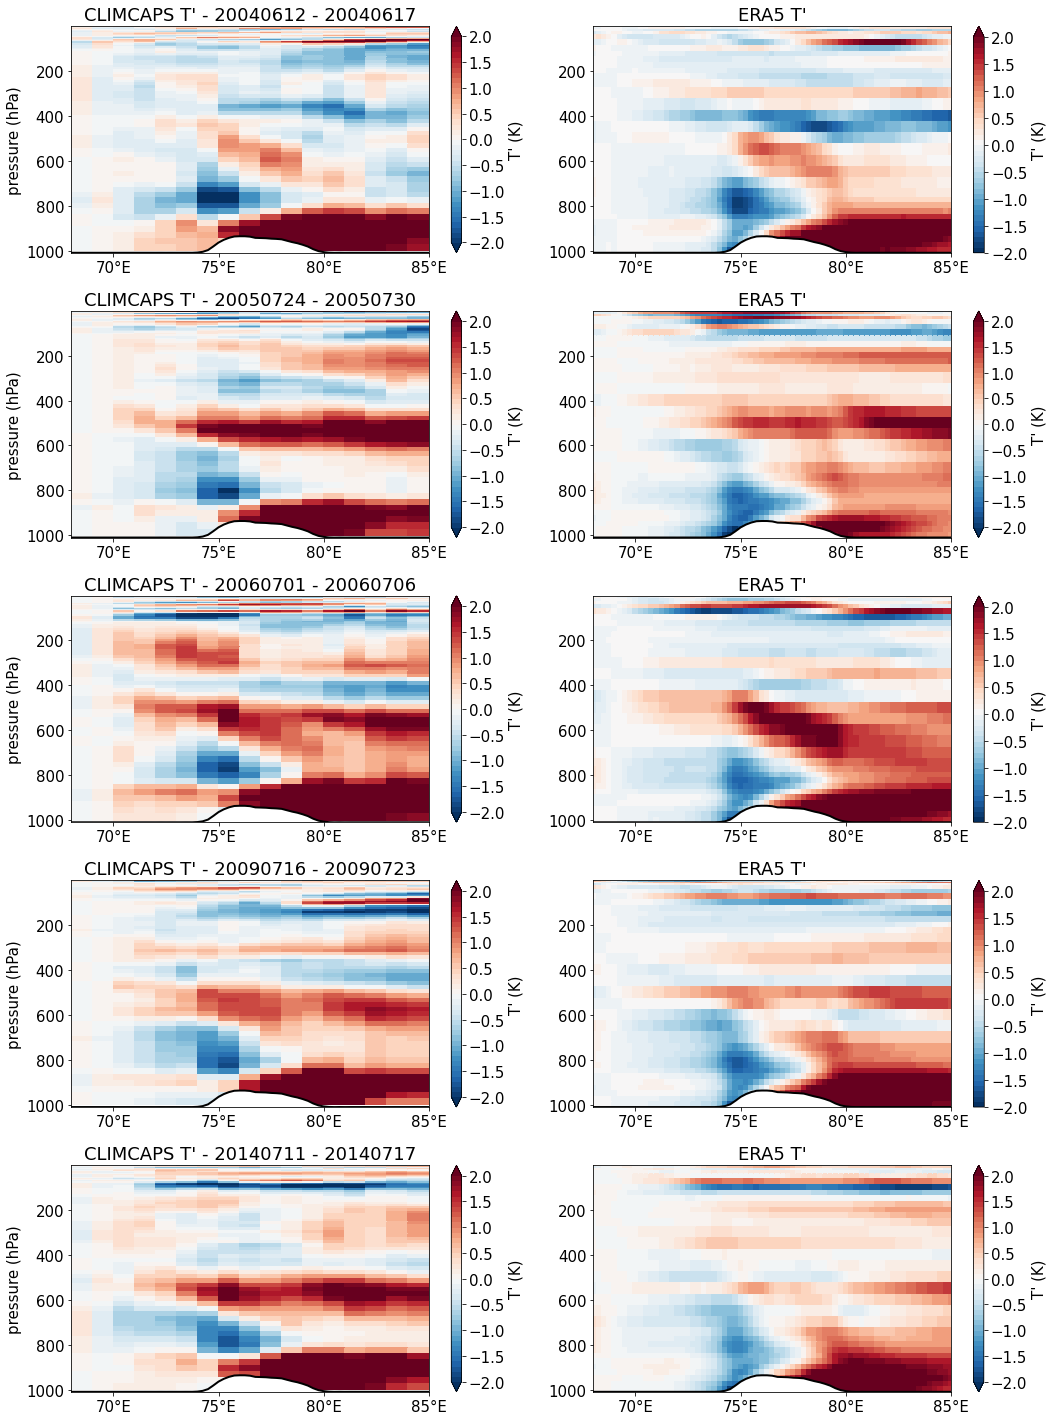

In [53]:
fig,axs = plt.subplots(5,2,figsize=(15,20))
for i,(ax1,ax2) in zip([2,3,6,-6,-3],axs):
    days = np.array(uitg_upstream_daily[itgwindyspells_start[i]:itgwindyspells_end[i]].time)
    days_str = pd.to_datetime(days).strftime('%Y%m%d')
    
    era5t = era5t_ghatswide_jjahourly.sel(time=slice(days_str[0],days_str[-1])).sel(latitude=slice(15,13)).mean(['time','latitude']).load()
    era5tprime = era5t-era5t.sel(longitude=slice(68,70)).mean('longitude')

    airst = climcapst_ghatswide_jjadaily.sel(time=slice(days_str[0],days_str[-1])).sel(latitude=slice(15,13)).mean(['time','latitude']).load()
    airstprime=airst-airst.sel(longitude=slice(68,70)).mean('longitude')
    
    #airs T
    airstprime.plot(ax=ax1,y='level',yincrease=False,levels=np.linspace(-2,2,41),cmap=plt.cm.RdBu_r,cbar_kwargs={'label':"T' (K)"})
    #ERA5"T'
    era5tprime.plot(ax=ax2,y='level',yincrease=False,levels=np.linspace(-2,2,41),cmap=plt.cm.RdBu_r,cbar_kwargs={'label':"T' (K)"})

    for ax in (ax1,ax2):
        ax.fill_between(ghatswide_topo.longitude,1010*ghatswide_topo**0,1010-ghatswide_topo/10,color='w')
        (1010-ghatswide_topo/10).plot(ax=ax,color='k',linewidth=2)
        ax.set_xlim(68,85)
        ax.set_ylim(1010,1)
        ax.set_xlabel('')
        lons=range(70,86,5)
        ax.set_xticks(lons)
        ax.set_xticklabels(["%i°E"%lon for lon in lons])
    ax1.set_title("CLIMCAPS T' - "+days_str[0]+" - "+days_str[-1])
    ax2.set_title("ERA5 T'")
    ax1.set_ylabel('pressure (hPa)')
    ax2.set_ylabel('')
fig.tight_layout()

In [48]:
import wrf
ghats_ideal_temp_z=xr.open_dataarray("/global/cscratch1/sd/qnicolas/wrfdata/saved/gw.wrf.2D.60lev.10km/diags/wrf.TEMP.zinterp.days0-10.nc")
ghats_ideal = xr.open_dataset("/global/cscratch1/sd/qnicolas/wrfdata/saved/gw.wrf.2D.60lev.10km/wrfout_d01_1970-01-01_00_00_00")
z0 = wrf.destagger((ghats_ideal.PH[-1,:,:,0].mean('south_north') + ghats_ideal.PHB[-1,:,0,0])/9.81,0)
p0 = (ghats_ideal.P[-1,:,:,0].mean('south_north') + ghats_ideal.PB[-1,:,0,0])
p_equiv = interp1d(z0,p0,fill_value='extrapolate')(ghats_ideal_temp_z.z)


In [49]:
ghats_ideal_tprime_z = ghats_ideal_temp_z[-1]-ghats_ideal_temp_z[-1].sel(distance_from_mtn=slice(-800,-600)).mean('distance_from_mtn')
ghats_ideal_tprime_z=ghats_ideal_tprime_z.assign_coords({'pressure (hPa)':('z',p_equiv/100)})

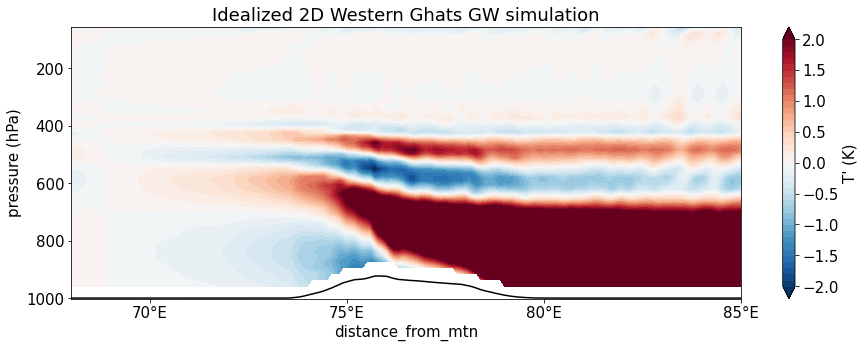

In [56]:
fig,ax = plt.subplots(1,1,figsize=(15,5))
ghats_ideal_tprime_z.plot.contourf(ax=ax,x='distance_from_mtn',y='pressure (hPa)',yincrease=False,levels=np.linspace(-2,2,41),cbar_kwargs={'label':"T' (K)"})
p_sfc = 999-ghats_ideal.HGT[0,0]/(1.1*9.81)
ax.plot(ghats_ideal_tprime_z.distance_from_mtn,p_sfc,color='k')
ax.set_xlim(-800,900)
ax.set_xticks(range(-600,901,500))
ax.set_xticklabels(["%i°E"%lon for lon in lons])
ax.set_title('Idealized 2D Western Ghats GW simulation')
ax.set_xlabel=('')

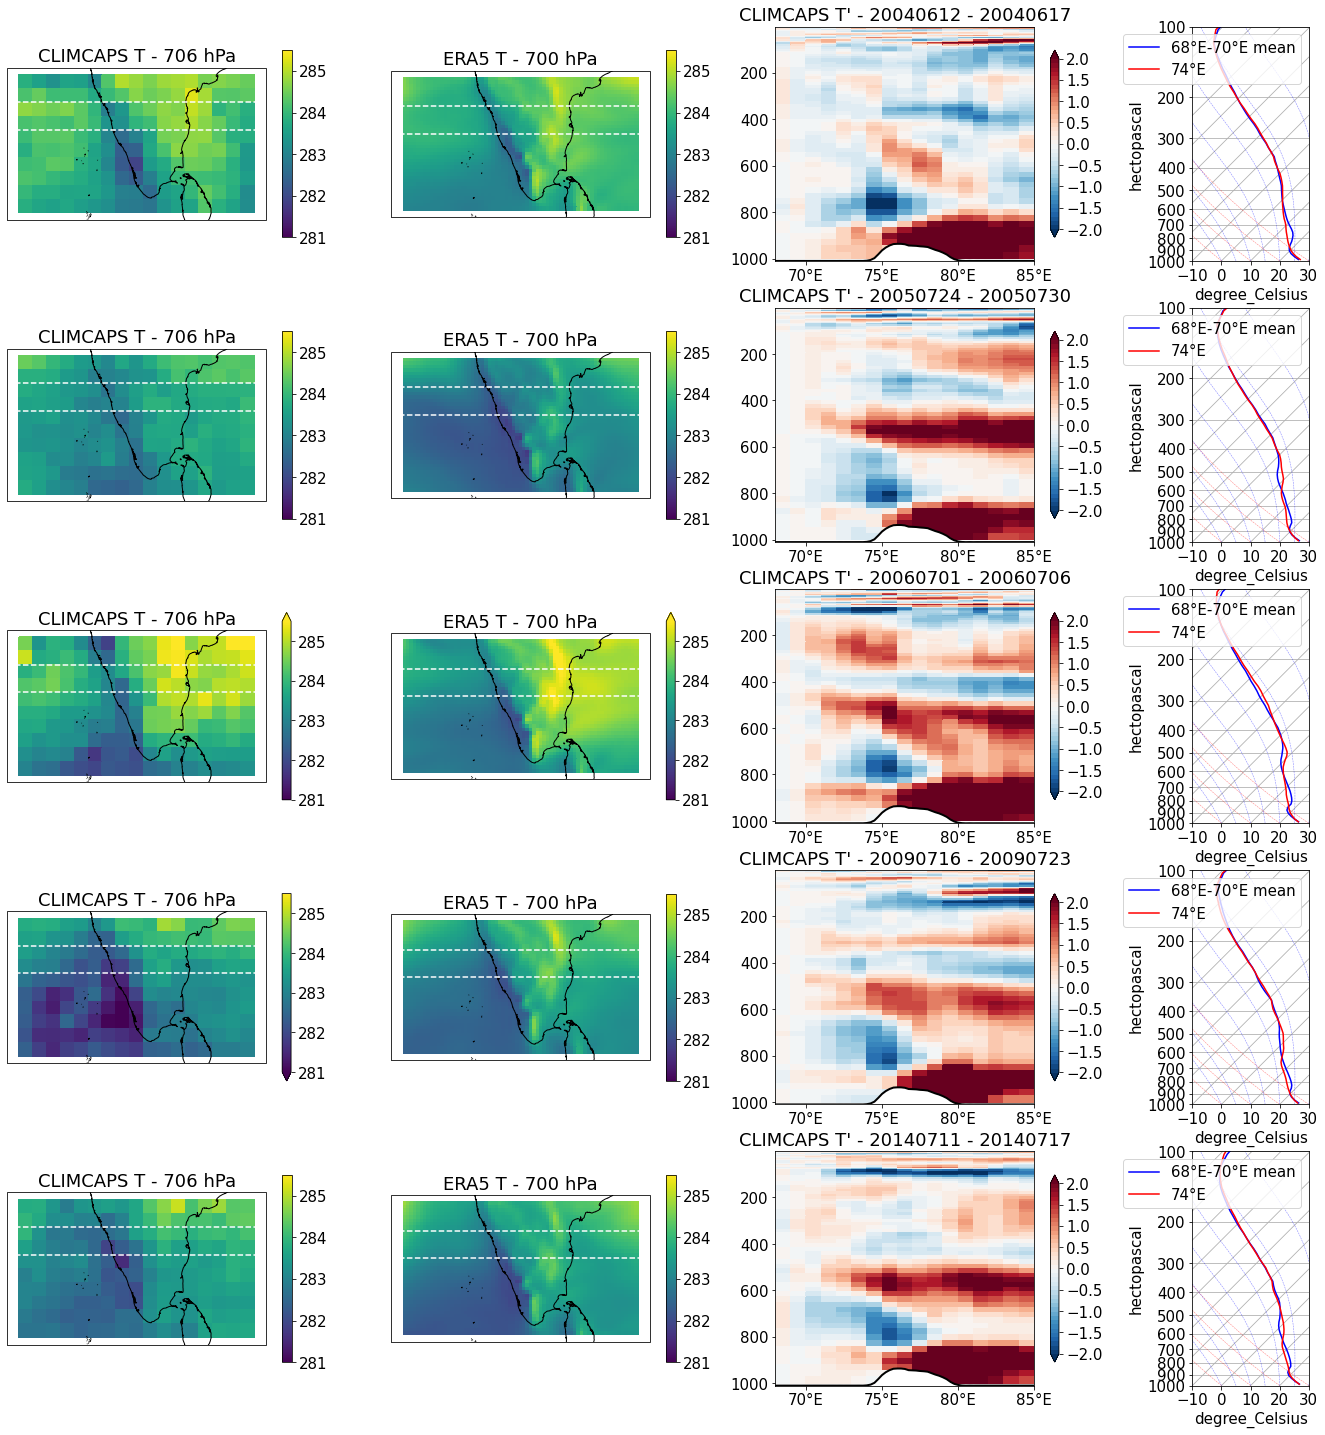

In [101]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(25,25))
spec = gridspec.GridSpec(nrows=5, ncols=4,width_ratios=[2,2,2,1.5],figure=fig)

for j,i in enumerate([2,3,6,-6,-3]):
    ax1 = fig.add_subplot(spec[4*j+0],projection= ccrs.PlateCarree())
    ax2 = fig.add_subplot(spec[4*j+1],projection= ccrs.PlateCarree())
    ax3 = fig.add_subplot(spec[4*j+2])
    skew = SkewT(fig,subplot=(5,4,4*j+4), rotation=45)
    days = np.array(uitg_upstream_daily[itgwindyspells_start[i]:itgwindyspells_end[i]].time)
    days_str = pd.to_datetime(days).strftime('%Y%m%d')
    
    era5t_map = era5t_ghatswide_jjahourly.sel(time=slice(days_str[0],days_str[-1])).sel(level=700.).mean(['time']).load()
    era5t = era5t_ghatswide_jjahourly.sel(time=slice(days_str[0],days_str[-1])).sel(latitude=slice(15,13)).mean(['time','latitude']).load()
    era5tprime = era5t-era5t.sel(longitude=slice(68,70)).mean('longitude')

    airst_map = climcapst_ghatswide_jjadaily.sel(time=slice(days_str[0],days_str[-1])).sel(level=700.,method='nearest').mean(['time']).load()
    airst = climcapst_ghatswide_jjadaily.sel(time=slice(days_str[0],days_str[-1])).sel(latitude=slice(15,13)).mean(['time','latitude']).load()
    airstprime=airst-airst.sel(longitude=slice(68,70)).mean('longitude')
    
    #airs T
    airst_map.plot(ax=ax1,transform=ccrs.PlateCarree(),vmin=281,vmax=285.5,cbar_kwargs={'shrink':0.8,'label':''})   
    #ERA5 T
    era5t_map.plot(ax=ax2,transform=ccrs.PlateCarree(),vmin=281,vmax=285.5,cbar_kwargs={'shrink':0.8,'label':''})
    #AIRS T'
    airstprime.plot(ax=ax3,y='level',yincrease=False,levels=np.linspace(-2,2,41),cmap=plt.cm.RdBu_r,cbar_kwargs={'shrink':0.8,'label':""})
    ## AIRS T soundings
    #airst.sel(longitude=slice(68,70)).mean('longitude').plot(ax=ax4,y='level',yincrease=False,color='b',label='68°E-70°E mean')
    #airst.sel(longitude=74.5).plot(ax=ax4,y='level',yincrease=False,color='r',label='74°E')
    P = np.array(airst.level)* units.hPa
    # AIRS T soundings
    skew.plot(P,units.degK*np.array(airst.sel(longitude=slice(68,70)).mean('longitude')),color='b',label='68°E-70°E mean')
    skew.plot(P,units.degK*np.array(airst.sel(longitude=74.5)),color='r',label='74°E')

    skew.ax.set_ylim(1000, 100)
    skew.ax.set_xlim(-10, 30)
    skew.ax.legend(fontsize=8)
    skew.plot_dry_adiabats(linewidth=0.5)
    skew.plot_moist_adiabats(linewidth=0.5)
    
    for ax in (ax3,):
        ax.fill_between(ghatswide_topo.longitude,1010*ghatswide_topo**0,1010-ghatswide_topo/10,color='w')
        (1010-ghatswide_topo/10).plot(ax=ax,color='k',linewidth=2)
        ax.set_xlim(68,85)
        ax.set_ylim(1010,1)
        ax.set_xlabel('')
        lons=range(70,86,5)
        ax.set_xticks(lons)
        ax.set_xticklabels(["%i°E"%lon for lon in lons])
    
    ax1.set_title("CLIMCAPS T - %i hPa"%airst_map.level)
    ax2.set_title("ERA5 T - 700 hPa")        
    ax3.set_title("CLIMCAPS T' - "+days_str[0]+" - "+days_str[-1])
    ax3.set_ylabel('')
    #ax4.set_ylabel('')
    #ax4.set_title("CLIMCAPS T soudings")
    #ax4.legend(fontsize=8)
    ax1.coastlines();ax2.coastlines()
    ax1.axhline(13,color='w',linestyle='--');ax1.axhline(15,color='w',linestyle='--')
    ax2.axhline(13,color='w',linestyle='--');ax2.axhline(15,color='w',linestyle='--')



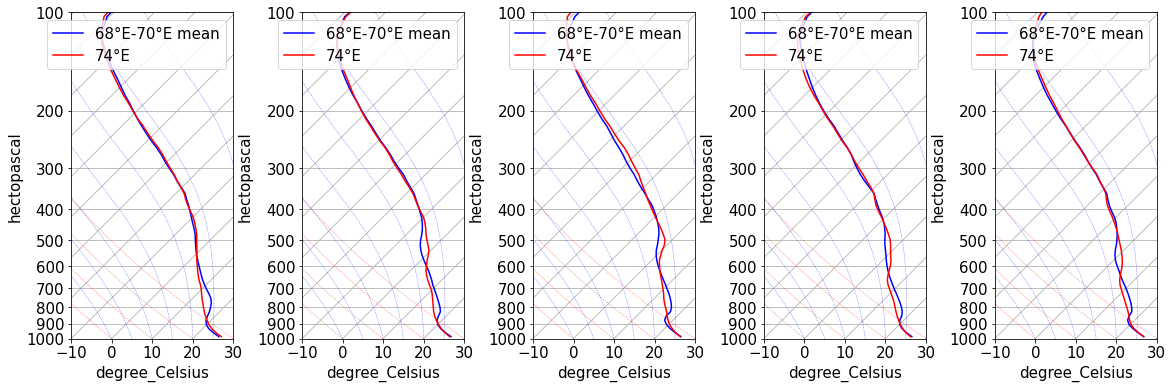

In [98]:
import metpy.calc as mpcalc
from metpy.plots import SkewT
from metpy.units import units

#fig,axs = plt.subplots(1,5,figsize=(25,6))
fig = plt.figure(figsize=(20,6))
for j,i in enumerate([2,3,6,-6,-3]):
    
    days = np.array(uitg_upstream_daily[itgwindyspells_start[i]:itgwindyspells_end[i]].time)
    days_str = pd.to_datetime(days).strftime('%Y%m%d')
    airst = climcapst_ghatswide_jjadaily.sel(time=slice(days_str[0],days_str[-1])).sel(latitude=slice(15,13)).mean(['time','latitude']).load()
    

